In [1]:
import urllib
from sqlalchemy import create_engine

import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta
from time import time

from efficient_apriori import apriori
from matplotlib import pyplot as plt

Very_Start = time()

### DEFINITION DE TOUS LES PARAMETRES

In [2]:
# @param Does it save the figure ?
save_fig    = False
save_folder = 'UC3_fig'

# @param Connexion à la DB
driver   = '{ODBC Driver 17 for SQL Server}'
server   = 'E5591-9S6YMV2'
username = 'WVN\k.dubrulle'
login    = ('DRIVER=' + driver + 
         ';SERVER='   + server + 
         ';Trusted_Connection=yes;')

# @param Definition des table et colonnes --> Dépendent de la DB
DB            = "Archive2018_2019_prod"
TABLE_ENTETE  = "Recette_entete_ticket"
TEMPS_ENTETE  = TABLE_ENTETE             + ".TEMPS.KEY_Date_reel_de_la_transaction"
NUMERO_ENTETE = TABLE_ENTETE             + ".Numero_ticket"
TABLE_DETAIL  = "Recette_detail_ticket"
TEMPS_DETAIL  = TABLE_DETAIL             + ".TEMPS.KEY_Date_reel_transaction"
NUMERO_DETAIL = TABLE_DETAIL             + ".Numero_ticket"
TABLE_ARTICLE = "Article_meti_HIST"
TABLE_UNIVERS = "Univers"
TABLE_MAGASIN = "Magasin"

Univers_Depth  = 4            # Jusqu'où on ira dans l'univers ? = [1;4]

# @param Variable influançant la sélection des données
nbr_ticket_max = 5000000   # MAX = 26.671.566 --- ~ 4 data / ticket

# @param Permet de faire varier l'analyse
min_sup     = 0.0005       # support minimum analysé  
max_sup     = 0.004        # support maximum analysé
sup_iter    = 4            # Nombre d'itération - 1 fait sur la variantion de support
min_conf    = 0.2          # confiance minimum analysée
max_conf    = 0.7          # confiance maximum analysée
conf_iter   = 5            # Nombre d'itération - 1 fait sur la variantion de confiance
do_analysis = False        # Est-ce qu'on fait l'analyse ou non ? 

# @param du modèle prédictif
min_support    = 0         # Seuil de support minimal souhaité   -> 1/#univers ~= 1/500  --> -1 => auto 
min_confidence = 1/5       # Seuil de confiance minimal souhaité -> 1/3        ~= 33% 

In [3]:
# TEST Connexion
params = urllib.parse.quote_plus(login)
engine = create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

conn = engine.connect()

df = pd.read_sql("SELECT TOP(10) ["+TABLE_ARTICLE+".KEY] FROM ["+DB+"].[DWH].[Dim_"+TABLE_ARTICLE+"]", conn)
print(df)

conn.close()

   Article_meti_HIST.KEY
0                     -1
1                      1
2                      2
3                      3
4                      4
5                      5
6                      6
7                      7
8                      8
9                      9


# GROUPEMENT D'ARTICLE

In [4]:
def date_to_key(d):
    return d.year*10000 + d.month*100 + d.day

start = time()

sql_command = '''SELECT [''' + TABLE_ARTICLE + '''.''' + TABLE_UNIVERS + '''.KEY],
['''     + TABLE_ENTETE  + '''.KEY],
['''     + TABLE_ENTETE  + '''.''' + TABLE_MAGASIN + '''.KEY]
FROM ['''       + DB + '''].[DWH].[Dim_'''  + TABLE_ARTICLE   + ''']
INNER JOIN [''' + DB + '''].[DWH].[Fact_''' + TABLE_DETAIL    + ''']
ON ['''  + TABLE_ARTICLE + '''.KEY] = ['''  + TABLE_DETAIL    + '''.''' + TABLE_ARTICLE + '''.KEY]
INNER JOIN [''' + DB + '''].[DWH].[Fact_''' + TABLE_ENTETE    + '''] 
ON ['''  + TEMPS_DETAIL  + '''] = ['''      + TEMPS_ENTETE    + '''] 
AND [''' + NUMERO_DETAIL + '''] = ['''      + NUMERO_ENTETE   + ''']
WHERE ['''    + TABLE_ARTICLE + '''.'''     + TABLE_UNIVERS   + '''.KEY] != -1 
AND ['''      + TABLE_ENTETE  + '''.Nombre_articles] > 0 
AND ['''      + TABLE_ENTETE  + '''.KEY] < ''' + str(nbr_ticket_max) + '''
AND [''' + TABLE_ARTICLE + '''.''' + TABLE_UNIVERS + '''.KEY] != 388
ORDER BY [''' + TABLE_ENTETE  + '''.KEY]'''

print(sql_command)

conn = engine.connect()
df_art_ticket = pd.read_sql(sql_command, conn)
conn.close()

# environ 4min
print("Time Taken to load DB: ~" + str(int(time() - start)) + "secondes") 
nbr_data = len(df_art_ticket)
print(df_art_ticket)

SELECT [Article_meti_HIST.Univers.KEY],
[Recette_entete_ticket.KEY],
[Recette_entete_ticket.Magasin.KEY]
FROM [Archive2018_2019_prod].[DWH].[Dim_Article_meti_HIST]
INNER JOIN [Archive2018_2019_prod].[DWH].[Fact_Recette_detail_ticket]
ON [Article_meti_HIST.KEY] = [Recette_detail_ticket.Article_meti_HIST.KEY]
INNER JOIN [Archive2018_2019_prod].[DWH].[Fact_Recette_entete_ticket] 
ON [Recette_detail_ticket.TEMPS.KEY_Date_reel_transaction] = [Recette_entete_ticket.TEMPS.KEY_Date_reel_de_la_transaction] 
AND [Recette_detail_ticket.Numero_ticket] = [Recette_entete_ticket.Numero_ticket]
WHERE [Article_meti_HIST.Univers.KEY] != -1 
AND [Recette_entete_ticket.Nombre_articles] > 0 
AND [Recette_entete_ticket.KEY] < 20000000
AND [Article_meti_HIST.Univers.KEY] != 388
ORDER BY [Recette_entete_ticket.KEY]
Time Taken to load DB: ~620secondes
          Article_meti_HIST.Univers.KEY  Recette_entete_ticket.KEY  \
0                                   148                          2   
1                    

In [5]:
start = time()

sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY],
    [''' + TABLE_UNIVERS  + '''.Libelle_univers1_FR], 
    [''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR], 
    [''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR], 
    [''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR]
    FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']'''
print(sql_command)

conn = engine.connect()
df_univers = pd.read_sql(sql_command, conn)
conn.close()

# environ 1s
print("Time Taken to load DB: ~" + str(int(time() - start)) + "secondes") 
print(df_univers)

SELECT [Univers.KEY],
    [Univers.Libelle_univers1_FR], 
    [Univers.Libelle_univers2_FR], 
    [Univers.Libelle_univers3_FR], 
    [Univers.Libelle_univers4_FR]
    FROM [Archive2018_2019_prod].[DWH].[Dim_Univers]
Time Taken to load DB: ~0secondes
     Univers.KEY Univers.Libelle_univers1_FR Univers.Libelle_univers2_FR  \
0             -1                           ?                           ?   
1              1               PRET A MANGER      SERVICE TRAITEUR FROID   
2              2               PRET A MANGER                MEUBLE CHAUD   
3              3               PRET A MANGER                MEUBLE CHAUD   
4              4               PRET A MANGER                MEUBLE CHAUD   
..           ...                         ...                         ...   
485          485               PRET A MANGER                     SALADES   
486          486               PRET A MANGER                     SALADES   
487          487  APERITIF   ENTREES   TAPAS                     

In [6]:
univers_correspondance = {}
deleted = set()
for item in df_univers.values:
    if item[0] in deleted:
        continue
    for cor in df_univers.values: 
        if item[0] != cor[0]:
            if (
                item[1] == cor[1] and
                (item[2] == cor[2] or Univers_Depth < 2) and
                (item[3] == cor[3] or Univers_Depth < 3) and
                (item[4] == cor[4] or Univers_Depth < 4)
            ):
                univers_correspondance[cor[0]] = item[0]
                deleted.add(cor[0])
print(univers_correspondance)

{3: 2}


In [7]:
start = time()

transactions      = []
actual_key_ticket = -1
for item in df_art_ticket.values:
    key_univ = item[0]
    key_tic  = item[1]
    
    if actual_key_ticket != key_tic:
        if actual_key_ticket != -1:
            transactions.append(tuple(l))
        actual_key_ticket = key_tic
        l = []
        
    if key_univ in deleted:
        key_univ = univers_correspondance[key_univ]
    l.append(key_univ)
transactions.append(tuple(l))
print(transactions[:20])

# environ 10s * #tickets / 2.000.000.
print("Time Taken to load transaction: ~" + str(int(time() - start)) + "secondes") 

[(148, 148, 392), (69, 183, 392, 174, 357, 294, 129), (393, 358, 457, 393), (129, 400, 357), (468, 110, 394, 394, 456), (148, 357, 299), (437, 299), (452, 121, 477, 477, 396, 319, 219), (299, 299), (400, 148, 148, 400), (212, 176), (148, 148, 148, 403, 403, 148, 148, 403), (457, 409, 357), (211, 409, 251), (148, 272, 393), (457, 294, 392, 121), (470, 418, 392, 331), (151, 392, 272, 361, 231, 231), (392, 120, 457, 129, 403), (272, 297, 294)]
Time Taken to load transaction: ~39secondes


In [8]:
rec_article = {}
N = len(transactions)

for t in transactions:
    for art in t:
        if not str(art) in rec_article.keys():
            rec_article[str(art)] = 0
        rec_article[str(art)]+=1

for k in rec_article.keys():
    rec_article[k]/= N
print(N)

14900343


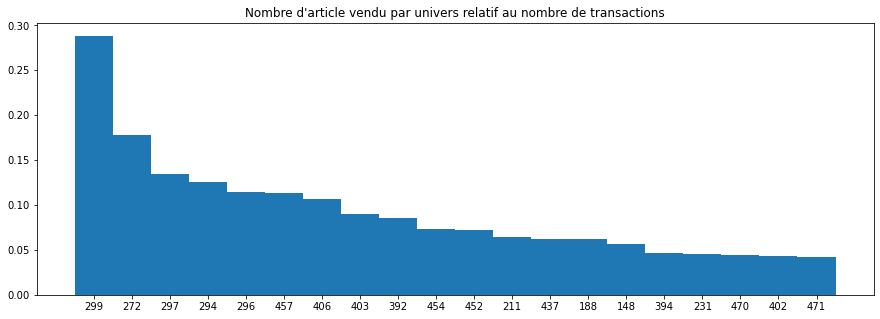

In [9]:
fig = plt.figure(figsize=(15, 5))

rec_article = {k: v for k, v in sorted(rec_article.items(), key=lambda item: item[1], reverse = True)}

nbr_univ = len(rec_article.keys())

plt.bar(list(rec_article.keys())[:min(20, nbr_univ)]
            ,list(rec_article.values())[:min(20, nbr_univ)],1)
        
plt.title("Nombre d'article vendu par univers relatif au nombre de transactions")
    
if save_fig:
    plt.savefig(save_folder+"/"+str(Univers_Depth)+"_Proportion-Article.jpg")
plt.show()

In [10]:
if do_analysis:
    data_rules = {}
    data_time  = {}
    for i_support in range(sup_iter+1):
        min_support = max_sup - i_support*(max_sup-min_sup)/sup_iter

        if min_support <= 0:
            break

        print(min_support, end = ': ')

        data_rules[min_support] = {}
        data_time[min_support]  = {}
        for i_confidence in range(conf_iter+1):
            min_confidence = max_conf - i_confidence*(max_conf-min_conf)/conf_iter

            print(min_confidence, end = '... ')

            start = time()
            _, rules = apriori(transactions, min_support=min_support, min_confidence=min_confidence)

            data_rules[min_support][min_confidence] = len(rules)
            data_time[min_support][min_confidence]  = int(time() - start)

        print(sum(data_time[min_support].values()), "secondes")


    df_rules = pd.DataFrame(data_rules)
    print(df_rules)
    df_time = pd.DataFrame(data_time)
    print(df_time)

In [18]:
start = time()

min_supp = 1/nbr_univ if min_support == 0 else min_support
print(min_supp)
                     
_, rules = apriori(transactions, min_support=min_supp, min_confidence=min_confidence)

# eniviron 30s*0.002/min_sup * #transactions / 2.500.000     
print("Time Taken to run Apriori Algorithm : ~" + str(int(time() - start)) + "secondes") 

0.002380952380952381
58


AttributeError: 'Rule' object has no attribute 'supp'

In [23]:
print(len(rules))
print(sum([r.support for r in rules])*0.05)
for rule in sorted(rules, key=lambda rule: rule.support):
    print(rule)

58
0.01513576902222989
{174} -> {452} (conf: 0.230, supp: 0.002, lift: 3.389, conv: 1.211)
{328} -> {454} (conf: 0.263, supp: 0.002, lift: 4.821, conv: 1.283)
{68} -> {297} (conf: 0.321, supp: 0.002, lift: 2.873, conv: 1.308)
{294, 296} -> {297} (conf: 0.250, supp: 0.003, lift: 2.238, conv: 1.184)
{406, 452} -> {403} (conf: 0.278, supp: 0.003, lift: 4.547, conv: 1.301)
{403, 452} -> {406} (conf: 0.330, supp: 0.003, lift: 4.383, conv: 1.379)
{408} -> {406} (conf: 0.232, supp: 0.003, lift: 3.084, conv: 1.204)
{169} -> {171} (conf: 0.206, supp: 0.003, lift: 8.348, conv: 1.228)
{294, 296} -> {299} (conf: 0.261, supp: 0.003, lift: 1.831, conv: 1.160)
{319} -> {454} (conf: 0.250, supp: 0.003, lift: 4.577, conv: 1.260)
{78} -> {57} (conf: 0.319, supp: 0.003, lift: 18.127, conv: 1.443)
{328} -> {461} (conf: 0.305, supp: 0.003, lift: 17.381, conv: 1.413)
{294, 299} -> {297} (conf: 0.202, supp: 0.003, lift: 1.807, conv: 1.113)
{408} -> {412} (conf: 0.256, supp: 0.003, lift: 9.943, conv: 1.309)
{

In [24]:
conn = engine.connect()

for rule in sorted(rules, key=lambda rule: rule.support):
    print("\n\nRule : ", rule)
    
    sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY] AS Univ_KEY, 
    ['''  + TABLE_UNIVERS  + '''.Libelle_univers1_FR] AS Univ_1 ''' + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR] AS Univ_2 ''')*int(Univers_Depth >= 2) + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR] AS Univ_3 ''')*int(Univers_Depth >= 3) + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR] AS Univ_4 ''')*int(Univers_Depth >= 4) + '''
    FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']
    WHERE '''
    for v in rule.lhs:
        sql_command += "[" + TABLE_UNIVERS  + ".KEY] = " + str(v) + "\nOR "
    sql_command = sql_command[:-3]

    df_libele = pd.read_sql(sql_command, conn)
    
    print(df_libele.to_string(index=False))
    print('->')
    
    sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY] AS Univ_KEY, 
    ['''  + TABLE_UNIVERS  + '''.Libelle_univers1_FR] AS Univ_1 ''' + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR] AS Univ_2 ''')*int(Univers_Depth >= 2) + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR] AS Univ_3 ''')*int(Univers_Depth >= 3) + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR] AS Univ_4 ''')*int(Univers_Depth >= 4) + '''
    FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']
    WHERE '''
    for v in rule.rhs:
        sql_command += "[" + TABLE_UNIVERS  + ".KEY] = " + str(v) + "\nOR "
    sql_command = sql_command[:-3]

    df_libele = pd.read_sql(sql_command, conn)
    
    print(df_libele.to_string(index=False))

conn.close()



Rule :  {174} -> {452} (conf: 0.230, supp: 0.002, lift: 3.389, conv: 1.211)
 Univ_KEY           Univ_1 Univ_2             Univ_3             Univ_4
      174 FRUITS   LEGUMES FRUITS ROUGES ET DES BOIS ROUGES ET DES BOIS
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {328} -> {454} (conf: 0.263, supp: 0.002, lift: 4.821, conv: 1.283)
 Univ_KEY                     Univ_1 Univ_2   Univ_3   Univ_4
      328 APERITIF   ENTREES   TAPAS  TAPAS FROMAGES FROMAGES
->
 Univ_KEY                     Univ_1                    Univ_2 Univ_3   Univ_4
      454 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS  CHIPS > 1 PERS


Rule :  {68} -> {297} (conf: 0.321, supp: 0.002, lift: 2.873, conv: 1.308)
 Univ_KEY          Univ_1      Univ_2  Univ_3  Univ_4
       68 PRET A CUISINER CHARCUTERIE SALAMIS SALAMIS
->
 Univ_KEY   

 Univ_KEY          Univ_1      Univ_2  Univ_3        Univ_4
       62 PRET A CUISINER CHARCUTERIE JAMBONS JAMBONS CUITS


Rule :  {62} -> {475} (conf: 0.243, supp: 0.004, lift: 13.000, conv: 1.296)
 Univ_KEY          Univ_1      Univ_2  Univ_3        Univ_4
       62 PRET A CUISINER CHARCUTERIE JAMBONS JAMBONS CUITS
->
 Univ_KEY          Univ_1  Univ_2    Univ_3   Univ_4
      475 PRET A CUISINER FROMAGE PATE DURE TRANCHES


Rule :  {475} -> {294} (conf: 0.240, supp: 0.004, lift: 2.500, conv: 1.189)
 Univ_KEY          Univ_1  Univ_2    Univ_3   Univ_4
      475 PRET A CUISINER FROMAGE PATE DURE TRANCHES
->
 Univ_KEY         Univ_1                       Univ_2    Univ_3    Univ_4
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES BAGUETTES


Rule :  {74} -> {297} (conf: 0.265, supp: 0.005, lift: 2.378, conv: 1.209)
 Univ_KEY          Univ_1 Univ_2 Univ_3 Univ_4
       74 PRET A CUISINER SPREAD SPREAD SPREAD
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Uni

In [13]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~897secondes


## Panier d'Articles par magasin

In [14]:
sql_command = '''  
SELECT ['''+TABLE_MAGASIN+'''.KEY]
      ,['''+TABLE_MAGASIN+'''.Libelle_magasin]
FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_MAGASIN+''']
'''
print(sql_command)


conn = engine.connect()
df_magasin = pd.read_sql(sql_command, conn)
conn.close()


print(df_magasin)

  
SELECT [Magasin.KEY]
      ,[Magasin.Libelle_magasin]
FROM [Archive2018_2019_prod].[DWH].[Dim_Magasin]

    Magasin.KEY Magasin.Libelle_magasin
0            -1                       ?
1             1                    None
2             2                  GENVAL
3             3            OHAIN F 2020
4             4                 JURBISE
..          ...                     ...
84           84    Franchise Uccle 2020
85           85           EXPANSION 535
86           86           EXPANSION 536
87           87           EXPANSION 537
88           88  DLTLU Match Laudelange

[89 rows x 2 columns]


In [15]:
all_mag_key = set(df_art_ticket[TABLE_ENTETE+"."+TABLE_MAGASIN + ".KEY"])

all_mag_lib = {mag_key:mag_lib for [mag_key,mag_lib] in df_magasin.values}
all_mag_tra = {mag_key:[] for mag_key in all_mag_key}

start = time()

actual_key_ticket = -1
for item in df_art_ticket.values:
    key_univ = item[0]
    key_tic  = item[1]
    key_mag  = item[2]

    if actual_key_ticket != key_tic:
        if actual_key_ticket != -1:
            all_mag_tra[key_mag].append(tuple(l))
        actual_key_ticket = key_tic
        l = []

    if key_univ in deleted:
        key_univ = univers_correspondance[key_univ]
    l.append(key_univ)
all_mag_tra[key_mag].append(tuple(l))

# environ 10s
print("Time Taken to run load transaction : ~" + str(int(time() - start)) + "secondes") 

Time Taken to run load transaction : ~51secondes


423951


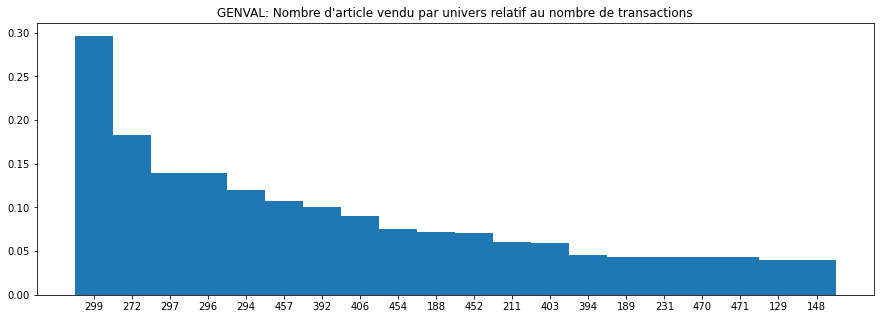

0.0024449877750611247
Running Apriori
52
{126} -> {272} (conf: 0.205, supp: 0.003, lift: 1.308, conv: 1.061)
{294, 297} -> {299} (conf: 0.200, supp: 0.003, lift: 1.410, conv: 1.073)
{394} -> {299} (conf: 0.204, supp: 0.006, lift: 1.439, conv: 1.078)
{231} -> {272} (conf: 0.236, supp: 0.008, lift: 1.511, conv: 1.105)
{296} -> {299} (conf: 0.257, supp: 0.018, lift: 1.808, conv: 1.155)
{294, 296} -> {299} (conf: 0.257, supp: 0.003, lift: 1.809, conv: 1.155)
{225} -> {299} (conf: 0.261, supp: 0.006, lift: 1.837, conv: 1.161)
{183} -> {297} (conf: 0.208, supp: 0.005, lift: 1.858, conv: 1.121)
{294, 299} -> {297} (conf: 0.211, supp: 0.003, lift: 1.887, conv: 1.126)
{22} -> {297} (conf: 0.213, supp: 0.003, lift: 1.900, conv: 1.128)
{169} -> {297} (conf: 0.213, supp: 0.003, lift: 1.902, conv: 1.128)
{171} -> {297} (conf: 0.216, supp: 0.004, lift: 1.932, conv: 1.133)
{296, 297} -> {299} (conf: 0.279, supp: 0.004, lift: 1.964, conv: 1.190)
{303} -> {297} (conf: 0.223, supp: 0.004, lift: 1.992, c

 Univ_KEY          Univ_1                     Univ_2  Univ_3  Univ_4
       18 PRET A CUISINER BEURRES   MATIERES GRASSES BEURRES BEURRES
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {52} -> {297} (conf: 0.274, supp: 0.003, lift: 2.450, conv: 1.224)
 Univ_KEY          Univ_1  Univ_2     Univ_3     Univ_4
       52 PRET A CUISINER FROMAGE PATE MOLLE PATE MOLLE
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {62} -> {297} (conf: 0.288, supp: 0.005, lift: 2.570, conv: 1.247)
 Univ_KEY          Univ_1      Univ_2  Univ_3        Univ_4
       62 PRET A CUISINER CHARCUTERIE JAMBONS JAMBONS CUITS
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {475} -> {294} (conf: 0.237, supp: 0.004, lift: 2

509274


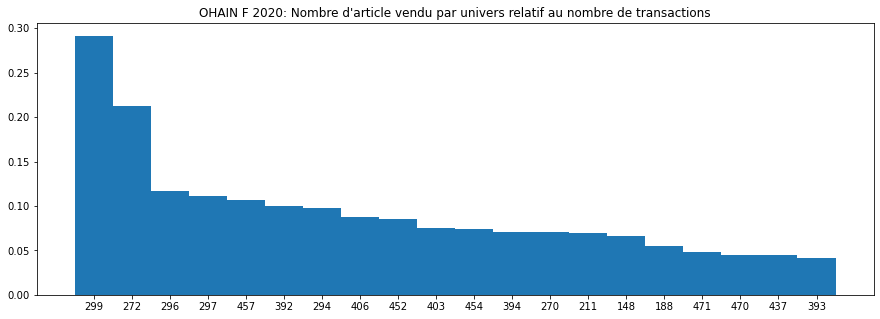

0.0024154589371980675
Running Apriori
81
{198} -> {272} (conf: 0.201, supp: 0.003, lift: 1.130, conv: 1.029)
{126} -> {272} (conf: 0.229, supp: 0.003, lift: 1.286, conv: 1.066)
{246} -> {272} (conf: 0.237, supp: 0.004, lift: 1.331, conv: 1.077)
{188} -> {272} (conf: 0.239, supp: 0.009, lift: 1.343, conv: 1.080)
{452, 457} -> {272} (conf: 0.247, supp: 0.003, lift: 1.390, conv: 1.092)
{250} -> {272} (conf: 0.249, supp: 0.006, lift: 1.399, conv: 1.095)
{297, 452} -> {299} (conf: 0.217, supp: 0.003, lift: 1.444, conv: 1.085)
{294, 297} -> {299} (conf: 0.222, supp: 0.002, lift: 1.479, conv: 1.093)
{231} -> {272} (conf: 0.273, supp: 0.009, lift: 1.536, conv: 1.131)
{239} -> {272} (conf: 0.313, supp: 0.002, lift: 1.762, conv: 1.197)
{225} -> {299} (conf: 0.277, supp: 0.005, lift: 1.844, conv: 1.175)
{294, 296} -> {299} (conf: 0.297, supp: 0.003, lift: 1.975, conv: 1.208)
{296} -> {299} (conf: 0.299, supp: 0.018, lift: 1.988, conv: 1.212)
{299, 452} -> {297} (conf: 0.201, supp: 0.003, lift: 2.

 Univ_KEY                     Univ_1                    Univ_2         Univ_3         Univ_4
      319 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS BISCUITS SALES BISCUITS SALES
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {296, 299} -> {297} (conf: 0.245, supp: 0.004, lift: 2.641, conv: 1.201)
 Univ_KEY         Univ_1                       Univ_2        Univ_3        Univ_4
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS    MINI PAINS    MINI PAINS
      299 PETIT DEJEUNER                 VIENNOISERIE VIENNOISERIES VIENNOISERIES
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {303} -> {452} (conf: 0.213, supp: 0.004, lift: 2.645, conv: 1.168)
 Univ_KEY         Univ_1            Univ_2     Univ_3

 Univ_KEY          Univ_1 Univ_2 Univ_3 Univ_4
       74 PRET A CUISINER SPREAD SPREAD SPREAD
->
 Univ_KEY         Univ_1                       Univ_2     Univ_3     Univ_4
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS MINI PAINS MINI PAINS


Rule :  {52} -> {294} (conf: 0.300, supp: 0.004, lift: 4.030, conv: 1.322)
 Univ_KEY          Univ_1  Univ_2     Univ_3     Univ_4
       52 PRET A CUISINER FROMAGE PATE MOLLE PATE MOLLE
->
 Univ_KEY         Univ_1                       Univ_2    Univ_3    Univ_4
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES BAGUETTES


Rule :  {297, 299} -> {296} (conf: 0.257, supp: 0.004, lift: 4.211, conv: 1.264)
 Univ_KEY         Univ_1                       Univ_2        Univ_3        Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS         PAINS         PAINS
      299 PETIT DEJEUNER                 VIENNOISERIE VIENNOISERIES VIENNOISERIES
->
 Univ_KEY         Univ_1                       Univ_2     Univ_3     Univ_4
   

333640


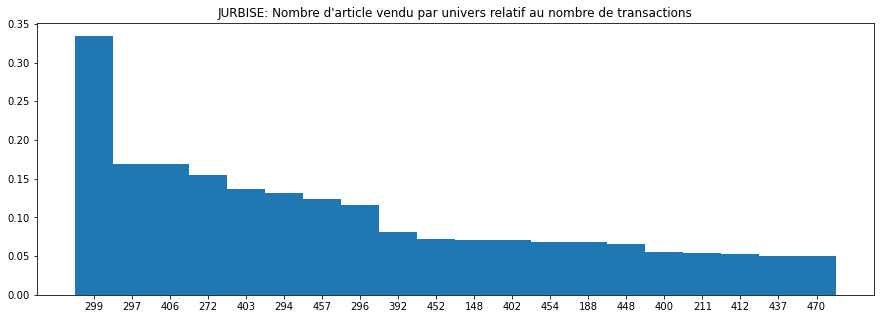

0.0024330900243309003
Running Apriori
126
{211} -> {299} (conf: 0.200, supp: 0.009, lift: 1.245, conv: 1.049)
{303} -> {299} (conf: 0.202, supp: 0.003, lift: 1.253, conv: 1.051)
{272, 457} -> {299} (conf: 0.205, supp: 0.003, lift: 1.276, conv: 1.056)
{452, 457} -> {299} (conf: 0.227, supp: 0.003, lift: 1.411, conv: 1.085)
{297, 452} -> {299} (conf: 0.230, supp: 0.003, lift: 1.430, conv: 1.090)
{272, 294} -> {299} (conf: 0.240, supp: 0.002, lift: 1.489, conv: 1.103)
{171} -> {297} (conf: 0.210, supp: 0.003, lift: 1.511, conv: 1.090)
{183} -> {297} (conf: 0.222, supp: 0.005, lift: 1.595, conv: 1.106)
{303} -> {297} (conf: 0.226, supp: 0.003, lift: 1.630, conv: 1.113)
{296, 297} -> {299} (conf: 0.266, supp: 0.004, lift: 1.657, conv: 1.144)
{231} -> {272} (conf: 0.217, supp: 0.008, lift: 1.659, conv: 1.110)
{296} -> {299} (conf: 0.271, supp: 0.015, lift: 1.683, conv: 1.151)
{299, 452} -> {297} (conf: 0.237, supp: 0.003, lift: 1.709, conv: 1.129)
{294, 296} -> {297} (conf: 0.245, supp: 0.00

 Univ_KEY   Univ_1    Univ_2        Univ_3        Univ_4
      438 BOISSONS JUS ZUMEX JUS ZUMEX >1P JUS ZUMEX >1P
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {402, 412} -> {406} (conf: 0.250, supp: 0.003, lift: 2.249, conv: 1.185)
 Univ_KEY        Univ_1         Univ_2       Univ_3       Univ_4
      402 PRET A MANGER PLATS PREPARES CHINESE FOOD CHINESE FOOD
      412 PRET A MANGER PLATS PREPARES    THAI FOOD    THAI FOOD
->
 Univ_KEY        Univ_1         Univ_2       Univ_3         Univ_4
      406 PRET A MANGER PLATS PREPARES ITALIAN FOOD PLATS ITALIENS


Rule :  {62} -> {294} (conf: 0.222, supp: 0.005, lift: 2.269, conv: 1.159)
 Univ_KEY          Univ_1      Univ_2  Univ_3        Univ_4
       62 PRET A CUISINER CHARCUTERIE JAMBONS JAMBONS CUITS
->
 Univ_KEY         Univ_1                       Univ_2    Univ_3    Univ_4
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTE

 Univ_KEY         Univ_1                       Univ_2       Univ_3         Univ_4
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS    BAGUETTES      BAGUETTES
      406  PRET A MANGER               PLATS PREPARES ITALIAN FOOD PLATS ITALIENS
->
 Univ_KEY        Univ_1         Univ_2         Univ_3          Univ_4
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD PLATS TRADITION


Rule :  {22} -> {294} (conf: 0.301, supp: 0.005, lift: 3.073, conv: 1.290)
 Univ_KEY          Univ_1    Univ_2 Univ_3 Univ_4
       22 PRET A CUISINER BOUCHERIE  BOEUF  BOEUF
->
 Univ_KEY         Univ_1                       Univ_2    Univ_3    Univ_4
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES BAGUETTES


Rule :  {299, 403} -> {406} (conf: 0.343, supp: 0.004, lift: 3.084, conv: 1.353)
 Univ_KEY         Univ_1         Univ_2         Univ_3          Univ_4
      299 PETIT DEJEUNER   VIENNOISERIE  VIENNOISERIES   VIENNOISERIES
      403  PRET A MANGER PLATS PREPARES TRADITION FOOD PLA

 Univ_KEY        Univ_1         Univ_2       Univ_3       Univ_4
      402 PRET A MANGER PLATS PREPARES CHINESE FOOD CHINESE FOOD


Rule :  {297, 454} -> {448} (conf: 0.367, supp: 0.003, lift: 5.990, conv: 1.483)
 Univ_KEY                     Univ_1                       Univ_2 Univ_3   Univ_4
      297             PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS    PAINS
      454 APERITIF   ENTREES   TAPAS    BISCUITERIE SALEE  SNACKS  CHIPS > 1 PERS
->
 Univ_KEY   Univ_1         Univ_2                 Univ_3                 Univ_4
      448 ECONOMAT ECONOMAT AUTRE FOURNITURE ET MATERIEL FOURNITURE ET MATERIEL


Rule :  {296, 448} -> {297} (conf: 0.833, supp: 0.004, lift: 6.000, conv: 5.161)
 Univ_KEY         Univ_1                       Univ_2                 Univ_3                 Univ_4
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS             MINI PAINS             MINI PAINS
      448       ECONOMAT               ECONOMAT AUTRE FOURNITURE ET MATERIEL FOURNITURE ET MATE

 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {272, 448} -> {297} (conf: 0.971, supp: 0.005, lift: 6.991, conv: 29.472)
 Univ_KEY          Univ_1             Univ_2                 Univ_3                 Univ_4
      272 TABACS   PRESSE TABAC   CIGARETTES     TABAC   CIGARETTES     TABAC   CIGARETTES
      448        ECONOMAT     ECONOMAT AUTRE FOURNITURE ET MATERIEL FOURNITURE ET MATERIEL
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {294, 448} -> {297} (conf: 0.974, supp: 0.007, lift: 7.015, conv: 33.280)
 Univ_KEY         Univ_1                       Univ_2                 Univ_3                 Univ_4
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS              BAGUETTES              BAGUETTES
      448       ECONOMAT               ECONOMAT AUTRE FOURNITURE ET MATERIEL FOURNIT

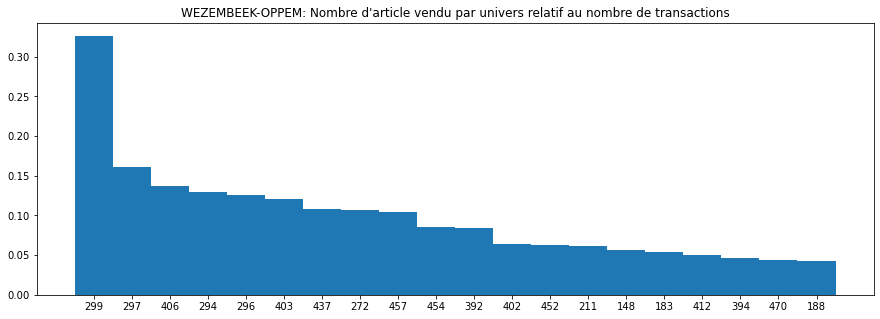

0.0024509803921568627
Running Apriori
89
{294, 297} -> {299} (conf: 0.200, supp: 0.004, lift: 1.338, conv: 1.063)
{225} -> {299} (conf: 0.221, supp: 0.005, lift: 1.475, conv: 1.091)
{174} -> {297} (conf: 0.202, supp: 0.003, lift: 1.543, conv: 1.089)
{134} -> {297} (conf: 0.215, supp: 0.003, lift: 1.648, conv: 1.108)
{13} -> {297} (conf: 0.217, supp: 0.006, lift: 1.657, conv: 1.110)
{171} -> {297} (conf: 0.224, supp: 0.007, lift: 1.712, conv: 1.120)
{294, 299} -> {297} (conf: 0.227, supp: 0.004, lift: 1.735, conv: 1.124)
{303} -> {297} (conf: 0.227, supp: 0.004, lift: 1.738, conv: 1.125)
{220} -> {299} (conf: 0.262, supp: 0.003, lift: 1.750, conv: 1.152)
{296} -> {299} (conf: 0.265, supp: 0.015, lift: 1.773, conv: 1.158)
{169} -> {297} (conf: 0.232, supp: 0.004, lift: 1.777, conv: 1.132)
{183} -> {297} (conf: 0.232, supp: 0.008, lift: 1.778, conv: 1.133)
{22} -> {297} (conf: 0.235, supp: 0.005, lift: 1.795, conv: 1.136)
{176} -> {297} (conf: 0.239, supp: 0.003, lift: 1.829, conv: 1.142)

 Univ_KEY          Univ_1  Univ_2         Univ_3         Univ_4
       54 PRET A CUISINER FROMAGE FRAIS   CHEVRE FRAIS   CHEVRE
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {296} -> {294} (conf: 0.216, supp: 0.012, lift: 2.271, conv: 1.154)
 Univ_KEY         Univ_1                       Univ_2     Univ_3     Univ_4
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS MINI PAINS MINI PAINS
->
 Univ_KEY         Univ_1                       Univ_2    Univ_3    Univ_4
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES BAGUETTES


Rule :  {462} -> {297} (conf: 0.302, supp: 0.004, lift: 2.312, conv: 1.246)
 Univ_KEY          Univ_1  Univ_2    Univ_3 Univ_4
      462 PRET A CUISINER FROMAGE PATE DURE   BLOC
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {296, 297} -> {294} (co

 Univ_KEY   Univ_1    Univ_2       Univ_3       Univ_4
      439 BOISSONS JUS ZUMEX JUS ZUMEX 1P JUS ZUMEX 1P
->
 Univ_KEY         Univ_1       Univ_2       Univ_3       Univ_4
      437 PETIT DEJEUNER CAFE SERVICE CAFE SERVICE CAFE SERVICE


Rule :  {406, 452} -> {403} (conf: 0.276, supp: 0.002, lift: 3.436, conv: 1.271)
 Univ_KEY        Univ_1                       Univ_2                       Univ_3                       Univ_4
      406 PRET A MANGER               PLATS PREPARES                 ITALIAN FOOD               PLATS ITALIENS
      452      ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE
->
 Univ_KEY        Univ_1         Univ_2         Univ_3          Univ_4
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD PLATS TRADITION


Rule :  {52} -> {294} (conf: 0.330, supp: 0.005, lift: 3.472, conv: 1.350)
 Univ_KEY          Univ_1  Univ_2     Univ_3     Univ_4
       52 PRET A CUISINER FROMAGE PATE MOLLE PATE MOLLE
->
 Univ_KE

 Univ_KEY          Univ_1  Univ_2     Univ_3     Univ_4
       56 PRET A CUISINER FROMAGE MOZZARELLA MOZZARELLA
->
 Univ_KEY           Univ_1  Univ_2         Univ_3 Univ_4
      183 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES FRUITS


Rule :  {62} -> {475} (conf: 0.259, supp: 0.004, lift: 11.840, conv: 1.320)
 Univ_KEY          Univ_1      Univ_2  Univ_3        Univ_4
       62 PRET A CUISINER CHARCUTERIE JAMBONS JAMBONS CUITS
->
 Univ_KEY          Univ_1  Univ_2    Univ_3   Univ_4
      475 PRET A CUISINER FROMAGE PATE DURE TRANCHES


Rule :  {328} -> {461} (conf: 0.352, supp: 0.003, lift: 14.987, conv: 1.508)
 Univ_KEY                     Univ_1 Univ_2   Univ_3   Univ_4
      328 APERITIF   ENTREES   TAPAS  TAPAS FROMAGES FROMAGES
->
 Univ_KEY                     Univ_1 Univ_2                  Univ_3                         Univ_4
      461 APERITIF   ENTREES   TAPAS  TAPAS CHARCUTERIE  SAUCISSONS PETITS SAUCISSONS (MINI/TRANC)


Rule :  {78} -> {57} (conf: 0.311, supp: 0.003, lift: 16.7

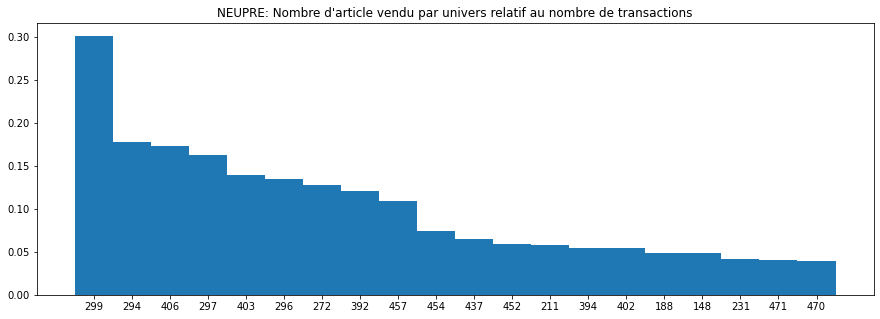

0.0024937655860349127
Running Apriori
97
{298} -> {299} (conf: 0.202, supp: 0.003, lift: 1.290, conv: 1.057)
{394} -> {299} (conf: 0.227, supp: 0.008, lift: 1.452, conv: 1.091)
{435} -> {294} (conf: 0.202, supp: 0.003, lift: 1.496, conv: 1.084)
{183} -> {294} (conf: 0.203, supp: 0.004, lift: 1.504, conv: 1.085)
{298} -> {297} (conf: 0.204, supp: 0.003, lift: 1.512, conv: 1.087)
{296} -> {294} (conf: 0.205, supp: 0.013, lift: 1.524, conv: 1.089)
{297, 299} -> {294} (conf: 0.207, supp: 0.005, lift: 1.535, conv: 1.091)
{296, 299} -> {294} (conf: 0.209, supp: 0.003, lift: 1.551, conv: 1.094)
{461} -> {294} (conf: 0.210, supp: 0.004, lift: 1.557, conv: 1.095)
{296, 297} -> {294} (conf: 0.212, supp: 0.003, lift: 1.570, conv: 1.097)
{171} -> {297} (conf: 0.212, supp: 0.004, lift: 1.574, conv: 1.098)
{296} -> {299} (conf: 0.246, supp: 0.016, lift: 1.577, conv: 1.120)
{294, 296} -> {299} (conf: 0.251, supp: 0.003, lift: 1.605, conv: 1.126)
{183} -> {297} (conf: 0.218, supp: 0.005, lift: 1.621, 

 Univ_KEY          Univ_1                     Univ_2  Univ_3  Univ_4
       18 PRET A CUISINER BEURRES   MATIERES GRASSES BEURRES BEURRES
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {220} -> {299} (conf: 0.341, supp: 0.004, lift: 2.181, conv: 1.280)
 Univ_KEY   Univ_1   Univ_2               Univ_3               Univ_4
      220 BOISSONS JUS SECS JUS DE FRUITS SEC 1P JUS DE FRUITS SEC 1P
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {52} -> {297} (conf: 0.295, supp: 0.003, lift: 2.186, conv: 1.227)
 Univ_KEY          Univ_1  Univ_2     Univ_3     Univ_4
       52 PRET A CUISINER FROMAGE PATE MOLLE PATE MOLLE
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {198} -> {299} (conf: 0.346, sup

 Univ_KEY        Univ_1         Univ_2       Univ_3         Univ_4
      406 PRET A MANGER PLATS PREPARES ITALIAN FOOD PLATS ITALIENS


Rule :  {297, 406} -> {403} (conf: 0.293, supp: 0.004, lift: 3.305, conv: 1.289)
 Univ_KEY         Univ_1                       Univ_2       Univ_3         Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS        PAINS          PAINS
      406  PRET A MANGER               PLATS PREPARES ITALIAN FOOD PLATS ITALIENS
->
 Univ_KEY        Univ_1         Univ_2         Univ_3          Univ_4
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD PLATS TRADITION


Rule :  {403, 412} -> {406} (conf: 0.404, supp: 0.003, lift: 3.543, conv: 1.486)
 Univ_KEY        Univ_1         Univ_2         Univ_3          Univ_4
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD PLATS TRADITION
      412 PRET A MANGER PLATS PREPARES      THAI FOOD       THAI FOOD
->
 Univ_KEY        Univ_1         Univ_2       Univ_3         Univ_4
      406 PRET A MANGER PLATS P

 Univ_KEY         Univ_1         Univ_2                 Univ_3                 Univ_4
      299 PETIT DEJEUNER   VIENNOISERIE          VIENNOISERIES          VIENNOISERIES
      448       ECONOMAT ECONOMAT AUTRE FOURNITURE ET MATERIEL FOURNITURE ET MATERIEL
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {408} -> {402} (conf: 0.328, supp: 0.006, lift: 7.879, conv: 1.426)
 Univ_KEY        Univ_1         Univ_2        Univ_3          Univ_4
      408 PRET A MANGER PLATS PREPARES JAPANESE FOOD PLATS JAPONNAIS
->
 Univ_KEY        Univ_1         Univ_2       Univ_3       Univ_4
      402 PRET A MANGER PLATS PREPARES CHINESE FOOD CHINESE FOOD


Rule :  {408} -> {412} (conf: 0.240, supp: 0.004, lift: 8.451, conv: 1.279)
 Univ_KEY        Univ_1         Univ_2        Univ_3          Univ_4
      408 PRET A MANGER PLATS PREPARES JAPANESE FOOD PLATS JAPONNAIS
->
 Univ_KEY        Univ_1         Uni

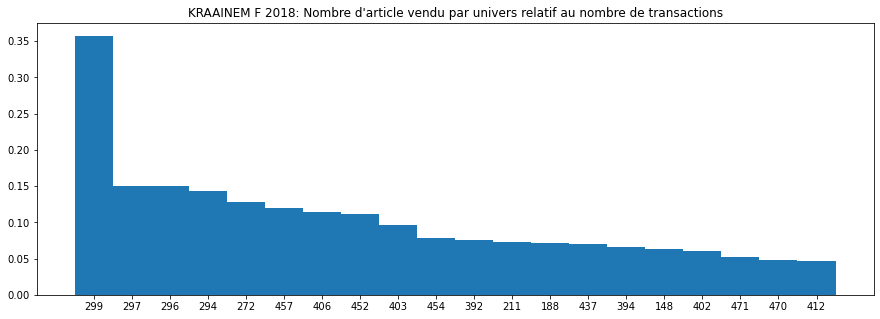

0.002564102564102564
Running Apriori
129
{297, 452} -> {299} (conf: 0.208, supp: 0.004, lift: 1.347, conv: 1.067)
{294, 297} -> {299} (conf: 0.230, supp: 0.004, lift: 1.494, conv: 1.099)
{225} -> {299} (conf: 0.241, supp: 0.006, lift: 1.562, conv: 1.114)
{294, 452} -> {299} (conf: 0.242, supp: 0.004, lift: 1.572, conv: 1.116)
{171} -> {297} (conf: 0.206, supp: 0.007, lift: 1.643, conv: 1.101)
{294, 299} -> {297} (conf: 0.208, supp: 0.004, lift: 1.660, conv: 1.104)
{169} -> {297} (conf: 0.212, supp: 0.003, lift: 1.693, conv: 1.110)
{22} -> {297} (conf: 0.212, supp: 0.004, lift: 1.695, conv: 1.110)
{13} -> {297} (conf: 0.215, supp: 0.006, lift: 1.718, conv: 1.114)
{296} -> {297} (conf: 0.217, supp: 0.016, lift: 1.735, conv: 1.118)
{174} -> {297} (conf: 0.219, supp: 0.003, lift: 1.752, conv: 1.121)
{294, 452} -> {297} (conf: 0.224, supp: 0.003, lift: 1.791, conv: 1.128)
{183} -> {297} (conf: 0.227, supp: 0.007, lift: 1.815, conv: 1.132)
{176} -> {297} (conf: 0.227, supp: 0.003, lift: 1.81

 Univ_KEY         Univ_1                       Univ_2     Univ_3     Univ_4
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS MINI PAINS MINI PAINS
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS      PAINS      PAINS
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {18} -> {452} (conf: 0.218, supp: 0.003, lift: 2.067, conv: 1.144)
 Univ_KEY          Univ_1                     Univ_2  Univ_3  Univ_4
       18 PRET A CUISINER BEURRES   MATIERES GRASSES BEURRES BEURRES
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {198} -> {299} (conf: 0.319, supp: 0.005, lift: 2.072, conv: 1.243)
 Univ_KEY         Univ_1          Univ_2     Univ_3     Univ_4
      198 PETIT DEJEUNER CAFE THE SUCRES CAFE FROID CAFE FROID
->


 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {413} -> {452} (conf: 0.250, supp: 0.004, lift: 2.377, conv: 1.193)
 Univ_KEY        Univ_1         Univ_2     Univ_3     Univ_4
      413 PRET A MANGER PLATS PREPARES GREEK FOOD GREEK FOOD
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {62} -> {452} (conf: 0.250, supp: 0.006, lift: 2.378, conv: 1.193)
 Univ_KEY          Univ_1      Univ_2  Univ_3        Univ_4
       62 PRET A CUISINER CHARCUTERIE JAMBONS JAMBONS CUITS
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A

 Univ_KEY         Univ_1                       Univ_2     Univ_3     Univ_4
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS MINI PAINS MINI PAINS


Rule :  {294, 299} -> {296} (conf: 0.223, supp: 0.005, lift: 3.058, conv: 1.193)
 Univ_KEY         Univ_1                       Univ_2        Univ_3        Univ_4
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS     BAGUETTES     BAGUETTES
      299 PETIT DEJEUNER                 VIENNOISERIE VIENNOISERIES VIENNOISERIES
->
 Univ_KEY         Univ_1                       Univ_2     Univ_3     Univ_4
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS MINI PAINS MINI PAINS


Rule :  {454, 457} -> {452} (conf: 0.331, supp: 0.003, lift: 3.141, conv: 1.337)
 Univ_KEY                     Univ_1                    Univ_2 Univ_3   Univ_4
      454 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS  CHIPS > 1 PERS
      457                   BOISSONS               SOFT DRINKS   SODA    COLAS
->
 Univ_KEY   Univ_1                       

 Univ_KEY           Univ_1  Univ_2         Univ_3 Univ_4
      183 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES FRUITS
->
 Univ_KEY          Univ_1        Univ_2  Univ_3  Univ_4
       13 PRET A CUISINER 4 ET 5  GAMME SALADES SALADES


Rule :  {13} -> {183} (conf: 0.261, supp: 0.007, lift: 7.945, conv: 1.308)
 Univ_KEY          Univ_1        Univ_2  Univ_3  Univ_4
       13 PRET A CUISINER 4 ET 5  GAMME SALADES SALADES
->
 Univ_KEY           Univ_1  Univ_2         Univ_3 Univ_4
      183 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES FRUITS


Rule :  {176} -> {171} (conf: 0.280, supp: 0.004, lift: 8.563, conv: 1.343)
 Univ_KEY           Univ_1 Univ_2 Univ_3 Univ_4
      176 FRUITS   LEGUMES FRUITS VERGER VERGER
->
 Univ_KEY           Univ_1 Univ_2   Univ_3   Univ_4
      171 FRUITS   LEGUMES FRUITS EXOTIQUE EXOTIQUE


Rule :  {475} -> {62} (conf: 0.266, supp: 0.006, lift: 10.866, conv: 1.328)
 Univ_KEY          Univ_1  Univ_2    Univ_3   Univ_4
      475 PRET A CUISINER FROMAGE PATE DURE TRANCHES


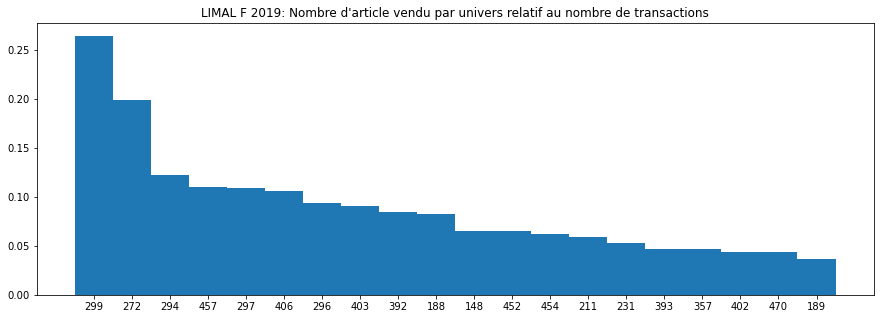

0.0024752475247524753
Running Apriori
38
{250} -> {272} (conf: 0.204, supp: 0.005, lift: 1.203, conv: 1.043)
{246} -> {272} (conf: 0.207, supp: 0.003, lift: 1.217, conv: 1.046)
{188} -> {272} (conf: 0.252, supp: 0.015, lift: 1.486, conv: 1.110)
{231} -> {272} (conf: 0.257, supp: 0.011, lift: 1.511, conv: 1.117)
{311} -> {272} (conf: 0.260, supp: 0.004, lift: 1.530, conv: 1.122)
{296} -> {299} (conf: 0.270, supp: 0.014, lift: 2.049, conv: 1.189)
{225} -> {299} (conf: 0.274, supp: 0.003, lift: 2.076, conv: 1.195)
{22} -> {297} (conf: 0.204, supp: 0.003, lift: 2.185, conv: 1.139)
{83} -> {297} (conf: 0.214, supp: 0.003, lift: 2.297, conv: 1.154)
{62} -> {294} (conf: 0.225, supp: 0.004, lift: 2.389, conv: 1.168)
{296, 297} -> {299} (conf: 0.324, supp: 0.003, lift: 2.458, conv: 1.284)
{296, 299} -> {297} (conf: 0.231, supp: 0.003, lift: 2.473, conv: 1.179)
{198} -> {299} (conf: 0.342, supp: 0.006, lift: 2.592, conv: 1.319)
{22} -> {294} (conf: 0.244, supp: 0.004, lift: 2.599, conv: 1.199)
{

 Univ_KEY          Univ_1  Univ_2     Univ_3     Univ_4
       52 PRET A CUISINER FROMAGE PATE MOLLE PATE MOLLE
->
 Univ_KEY         Univ_1                       Univ_2    Univ_3    Univ_4
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES BAGUETTES


Rule :  {74} -> {296} (conf: 0.203, supp: 0.004, lift: 4.025, conv: 1.191)
 Univ_KEY          Univ_1 Univ_2 Univ_3 Univ_4
       74 PRET A CUISINER SPREAD SPREAD SPREAD
->
 Univ_KEY         Univ_1                       Univ_2     Univ_3     Univ_4
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS MINI PAINS MINI PAINS


Rule :  {439} -> {299} (conf: 0.536, supp: 0.014, lift: 4.065, conv: 1.870)
 Univ_KEY   Univ_1    Univ_2       Univ_3       Univ_4
      439 BOISSONS JUS ZUMEX JUS ZUMEX 1P JUS ZUMEX 1P
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {297, 299} -> {296} (conf: 0.219, supp: 0.003, lift: 4.346, conv: 1.216)
 Univ

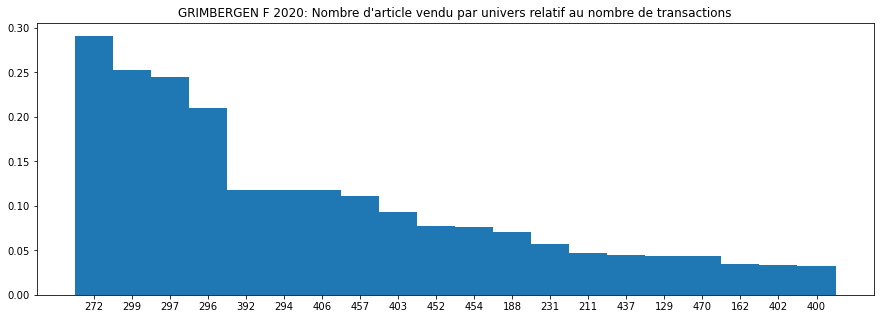

0.0024096385542168677
Running Apriori
130
{211} -> {272} (conf: 0.202, supp: 0.008, lift: 0.831, conv: 0.949)
{461} -> {272} (conf: 0.204, supp: 0.003, lift: 0.838, conv: 0.950)
{129} -> {272} (conf: 0.204, supp: 0.007, lift: 0.838, conv: 0.950)
{463} -> {272} (conf: 0.204, supp: 0.003, lift: 0.838, conv: 0.951)
{297, 457} -> {272} (conf: 0.214, supp: 0.003, lift: 0.878, conv: 0.962)
{470} -> {272} (conf: 0.219, supp: 0.008, lift: 0.898, conv: 0.968)
{452, 457} -> {272} (conf: 0.227, supp: 0.003, lift: 0.935, conv: 0.979)
{471} -> {272} (conf: 0.232, supp: 0.006, lift: 0.955, conv: 0.986)
{246} -> {272} (conf: 0.233, supp: 0.002, lift: 0.960, conv: 0.987)
{472} -> {272} (conf: 0.236, supp: 0.004, lift: 0.970, conv: 0.990)
{457} -> {272} (conf: 0.242, supp: 0.021, lift: 0.994, conv: 0.998)
{458} -> {272} (conf: 0.244, supp: 0.003, lift: 1.003, conv: 1.001)
{250} -> {272} (conf: 0.261, supp: 0.005, lift: 1.074, conv: 1.024)
{461} -> {297} (conf: 0.206, supp: 0.003, lift: 1.088, conv: 1.0

 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {406, 452} -> {297} (conf: 0.237, supp: 0.003, lift: 1.251, conv: 1.062)
 Univ_KEY        Univ_1                       Univ_2                       Univ_3                       Univ_4
      406 PRET A MANGER               PLATS PREPARES                 ITALIAN FOOD               PLATS ITALIENS
      452      ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {272, 452} -> {297} (conf: 0.243, supp: 0.003, lift: 1.284, conv: 1.071)
 Univ_KEY          Univ_1                       Univ_2                       Univ_3                       Univ_4
      272 TABACS   PRESSE           TABAC   CIGARETTES           TABAC   CIGARETTES           TABAC   CIGARETTES


 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {60} -> {297} (conf: 0.408, supp: 0.003, lift: 2.156, conv: 1.370)
 Univ_KEY          Univ_1      Univ_2      Univ_3      Univ_4
       60 PRET A CUISINER CHARCUTERIE CHIFFONADES CHIFFONADES
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {462} -> {297} (conf: 0.408, supp: 0.004, lift: 2.158, conv: 1.371)
 Univ_KEY          Univ_1  Univ_2    Univ_3 Univ_4
      462 PRET A CUISINER FROMAGE PATE DURE   BLOC
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {271} -> {272} (conf: 0.528, supp: 0.008, lift: 2.170, conv: 1.603)
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      271 TABACS   PRESSE TABAC   ACCESSOIRE

 Univ_KEY        Univ_1     Univ_2            Univ_3               Univ_4
      392 PRET A MANGER SANDWICHES SANDWICHES FROIDS SANDWICHES CLASSIQUE


Rule :  {74} -> {452} (conf: 0.215, supp: 0.003, lift: 2.951, conv: 1.181)
 Univ_KEY          Univ_1 Univ_2 Univ_3 Univ_4
       74 PRET A CUISINER SPREAD SPREAD SPREAD
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {393} -> {392} (conf: 0.264, supp: 0.007, lift: 2.994, conv: 1.239)
 Univ_KEY        Univ_1     Univ_2            Univ_3              Univ_4
      393 PRET A MANGER SANDWICHES SANDWICHES FROIDS SANDWICHES SPECIAUX
->
 Univ_KEY        Univ_1     Univ_2            Univ_3               Univ_4
      392 PRET A MANGER SANDWICHES SANDWICHES FROIDS SANDWICHES CLASSIQUE


Rule :  {475} -> {452} (conf: 0.219, supp: 0.004, lift: 3.009, conv: 1.187)
 Univ_KEY    

 Univ_KEY          Univ_1 Univ_2 Univ_3 Univ_4
       74 PRET A CUISINER SPREAD SPREAD SPREAD
->
 Univ_KEY         Univ_1                       Univ_2     Univ_3     Univ_4
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS MINI PAINS MINI PAINS


Rule :  {297, 403} -> {406} (conf: 0.306, supp: 0.003, lift: 3.814, conv: 1.325)
 Univ_KEY         Univ_1                       Univ_2         Univ_3          Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS          PAINS           PAINS
      403  PRET A MANGER               PLATS PREPARES TRADITION FOOD PLATS TRADITION
->
 Univ_KEY        Univ_1         Univ_2       Univ_3         Univ_4
      406 PRET A MANGER PLATS PREPARES ITALIAN FOOD PLATS ITALIENS


Rule :  {297, 406} -> {403} (conf: 0.239, supp: 0.003, lift: 3.890, conv: 1.233)
 Univ_KEY         Univ_1                       Univ_2       Univ_3         Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS        PAINS          PAINS
      406  PRET A MANGER     

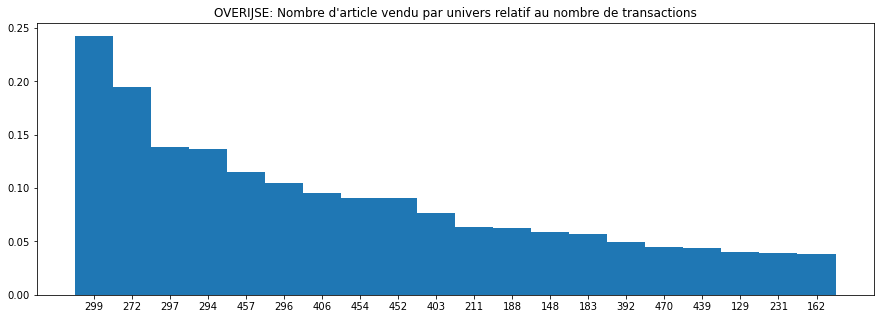

0.0024330900243309003
Running Apriori
102
{472} -> {272} (conf: 0.203, supp: 0.003, lift: 1.187, conv: 1.040)
{250} -> {272} (conf: 0.208, supp: 0.005, lift: 1.215, conv: 1.046)
{198} -> {272} (conf: 0.210, supp: 0.003, lift: 1.228, conv: 1.049)
{188} -> {272} (conf: 0.226, supp: 0.010, lift: 1.318, conv: 1.070)
{126} -> {272} (conf: 0.278, supp: 0.003, lift: 1.623, conv: 1.148)
{174} -> {297} (conf: 0.201, supp: 0.003, lift: 1.722, conv: 1.105)
{22} -> {297} (conf: 0.203, supp: 0.004, lift: 1.739, conv: 1.108)
{298} -> {299} (conf: 0.202, supp: 0.003, lift: 1.761, conv: 1.110)
{83} -> {297} (conf: 0.205, supp: 0.005, lift: 1.761, conv: 1.112)
{294, 452} -> {299} (conf: 0.203, supp: 0.003, lift: 1.763, conv: 1.110)
{294, 299} -> {297} (conf: 0.207, supp: 0.003, lift: 1.779, conv: 1.115)
{294, 452} -> {297} (conf: 0.208, supp: 0.003, lift: 1.786, conv: 1.116)
{225} -> {299} (conf: 0.205, supp: 0.003, lift: 1.788, conv: 1.114)
{231} -> {272} (conf: 0.309, supp: 0.010, lift: 1.805, conv: 

 Univ_KEY  Univ_1   Univ_2 Univ_3 Univ_4
      120 DESSERT CHOCOLAT BATONS BATONS
->
 Univ_KEY   Univ_1      Univ_2 Univ_3 Univ_4
      457 BOISSONS SOFT DRINKS   SODA  COLAS


Rule :  {52} -> {297} (conf: 0.262, supp: 0.003, lift: 2.249, conv: 1.197)
 Univ_KEY          Univ_1  Univ_2     Univ_3     Univ_4
       52 PRET A CUISINER FROMAGE PATE MOLLE PATE MOLLE
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {462} -> {297} (conf: 0.262, supp: 0.003, lift: 2.252, conv: 1.198)
 Univ_KEY          Univ_1  Univ_2    Univ_3 Univ_4
      462 PRET A CUISINER FROMAGE PATE DURE   BLOC
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {296} -> {299} (conf: 0.266, supp: 0.014, lift: 2.314, conv: 1.206)
 Univ_KEY         Univ_1                       Univ_2     Univ_3     Univ_4
      296 PETIT DEJEUNER

 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {68} -> {297} (conf: 0.312, supp: 0.003, lift: 2.677, conv: 1.284)
 Univ_KEY          Univ_1      Univ_2  Univ_3  Univ_4
       68 PRET A CUISINER CHARCUTERIE SALAMIS SALAMIS
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {475} -> {297} (conf: 0.314, supp: 0.008, lift: 2.693, conv: 1.288)
 Univ_KEY          Univ_1  Univ_2    Univ_3   Univ_4
      475 PRET A CUISINER FROMAGE PATE DURE TRANCHES
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {78} -> {452} (conf: 0.230, supp: 0.003, lift: 2.701, conv: 1.188)
 Univ_KEY          Univ_1      Univ_2 Univ_3 Univ_4
       78 PR

 Univ_KEY           Univ_1  Univ_2         Univ_3   Univ_4
      181 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES FEUILLES
->
 Univ_KEY           Univ_1  Univ_2         Univ_3 Univ_4
      183 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES FRUITS


Rule :  {412} -> {402} (conf: 0.231, supp: 0.006, lift: 7.494, conv: 1.260)
 Univ_KEY        Univ_1         Univ_2    Univ_3    Univ_4
      412 PRET A MANGER PLATS PREPARES THAI FOOD THAI FOOD
->
 Univ_KEY        Univ_1         Univ_2       Univ_3       Univ_4
      402 PRET A MANGER PLATS PREPARES CHINESE FOOD CHINESE FOOD


Rule :  {180} -> {183} (conf: 0.305, supp: 0.003, lift: 7.781, conv: 1.383)
 Univ_KEY           Univ_1  Univ_2         Univ_3 Univ_4
      180 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES BULBES
->
 Univ_KEY           Univ_1  Univ_2         Univ_3 Univ_4
      183 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES FRUITS


Rule :  {183, 452} -> {13} (conf: 0.281, supp: 0.002, lift: 8.917, conv: 1.347)
 Univ_KEY           Univ_1                   

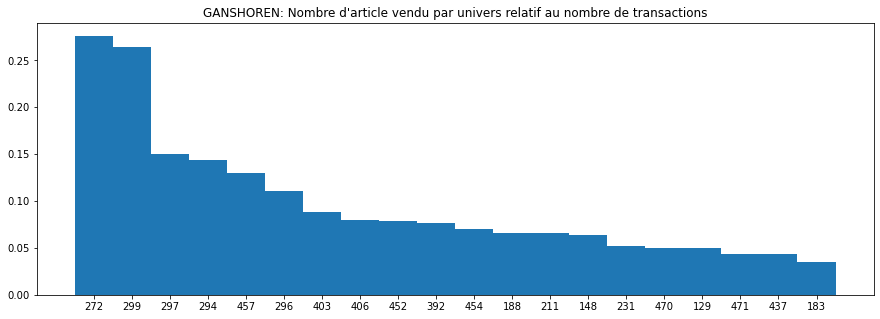

0.0024390243902439024
Running Apriori
79
{471} -> {272} (conf: 0.202, supp: 0.007, lift: 0.871, conv: 0.963)
{22} -> {272} (conf: 0.203, supp: 0.004, lift: 0.876, conv: 0.964)
{120} -> {272} (conf: 0.209, supp: 0.004, lift: 0.900, conv: 0.971)
{452} -> {272} (conf: 0.215, supp: 0.016, lift: 0.928, conv: 0.979)
{297, 452} -> {272} (conf: 0.216, supp: 0.003, lift: 0.932, conv: 0.980)
{198} -> {272} (conf: 0.217, supp: 0.004, lift: 0.937, conv: 0.981)
{246} -> {272} (conf: 0.221, supp: 0.004, lift: 0.953, conv: 0.986)
{294, 452} -> {272} (conf: 0.223, supp: 0.003, lift: 0.963, conv: 0.989)
{299, 452} -> {272} (conf: 0.229, supp: 0.003, lift: 0.989, conv: 0.997)
{472} -> {272} (conf: 0.232, supp: 0.003, lift: 1.000, conv: 1.000)
{193} -> {272} (conf: 0.233, supp: 0.004, lift: 1.003, conv: 1.001)
{457} -> {272} (conf: 0.250, supp: 0.026, lift: 1.077, conv: 1.024)
{250} -> {272} (conf: 0.255, supp: 0.007, lift: 1.098, conv: 1.031)
{454, 457} -> {272} (conf: 0.263, supp: 0.003, lift: 1.132, c

 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {299, 452} -> {297} (conf: 0.237, supp: 0.003, lift: 1.843, conv: 1.142)
 Univ_KEY         Univ_1                       Univ_2                       Univ_3                       Univ_4
      299 PETIT DEJEUNER                 VIENNOISERIE                VIENNOISERIES                VIENNOISERIES
      452       ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {296, 299} -> {297} (conf: 0.240, supp: 0.003, lift: 1.867, conv: 1.146)
 Univ_KEY         Univ_1                       Univ_2        Univ_3        Univ_4
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS    MINI PAINS    MINI PAINS
      299 PETIT DEJEUNER                 VIENNOISERIE VIENN

 Univ_KEY         Univ_1            Univ_2           Univ_3           Univ_4
      301 PETIT DEJEUNER PRODUITS LAITIERS LAITS CHOCOLATES LAITS CHOCOLATES
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {439} -> {299} (conf: 0.472, supp: 0.010, lift: 3.537, conv: 1.642)
 Univ_KEY   Univ_1    Univ_2       Univ_3       Univ_4
      439 BOISSONS JUS ZUMEX JUS ZUMEX 1P JUS ZUMEX 1P
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {74} -> {296} (conf: 0.208, supp: 0.004, lift: 3.663, conv: 1.191)
 Univ_KEY          Univ_1 Univ_2 Univ_3 Univ_4
       74 PRET A CUISINER SPREAD SPREAD SPREAD
->
 Univ_KEY         Univ_1                       Univ_2     Univ_3     Univ_4
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS MINI PAINS MINI PAINS


Rule :  {412} -> {403} (conf: 0.211, supp: 0.004, lift: 3.70

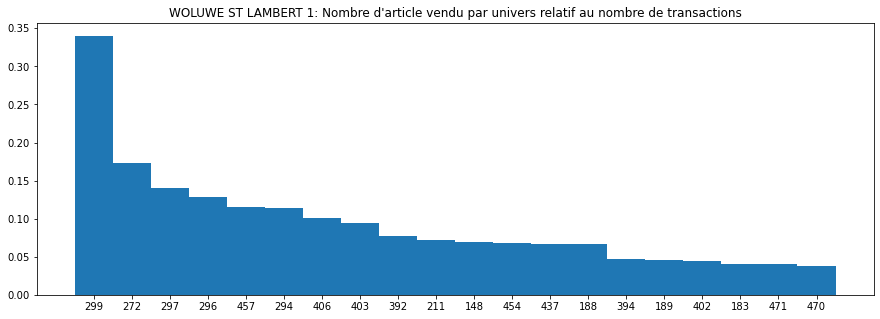

0.0024390243902439024
Running Apriori
58
{298} -> {299} (conf: 0.212, supp: 0.002, lift: 1.363, conv: 1.072)
{225} -> {299} (conf: 0.220, supp: 0.005, lift: 1.418, conv: 1.083)
{294, 297} -> {299} (conf: 0.224, supp: 0.003, lift: 1.443, conv: 1.089)
{220} -> {299} (conf: 0.225, supp: 0.003, lift: 1.449, conv: 1.090)
{188} -> {272} (conf: 0.214, supp: 0.009, lift: 1.493, conv: 1.090)
{277} -> {299} (conf: 0.248, supp: 0.004, lift: 1.595, conv: 1.123)
{296} -> {299} (conf: 0.254, supp: 0.015, lift: 1.634, conv: 1.132)
{231} -> {272} (conf: 0.240, supp: 0.007, lift: 1.672, conv: 1.127)
{171} -> {297} (conf: 0.211, supp: 0.006, lift: 1.809, conv: 1.120)
{296} -> {297} (conf: 0.212, supp: 0.012, lift: 1.812, conv: 1.120)
{303} -> {297} (conf: 0.215, supp: 0.004, lift: 1.845, conv: 1.126)
{183} -> {297} (conf: 0.220, supp: 0.006, lift: 1.887, conv: 1.133)
{176} -> {297} (conf: 0.223, supp: 0.003, lift: 1.905, conv: 1.136)
{13} -> {297} (conf: 0.223, supp: 0.004, lift: 1.906, conv: 1.136)
{29

 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {301} -> {299} (conf: 0.461, supp: 0.003, lift: 2.972, conv: 1.569)
 Univ_KEY         Univ_1            Univ_2           Univ_3           Univ_4
      301 PETIT DEJEUNER PRODUITS LAITIERS LAITS CHOCOLATES LAITS CHOCOLATES
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {475} -> {297} (conf: 0.369, supp: 0.007, lift: 3.160, conv: 1.400)
 Univ_KEY          Univ_1  Univ_2    Univ_3   Univ_4
      475 PRET A CUISINER FROMAGE PATE DURE TRANCHES
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {438} -> {299} (conf: 0.504, supp: 0.003, lift: 3.245, conv: 1.703)
 Univ_KEY   Univ_1    Univ_2        Univ_3        Univ_4
      438 BOISSONS JUS ZUMEX JUS ZUMEX 

354557


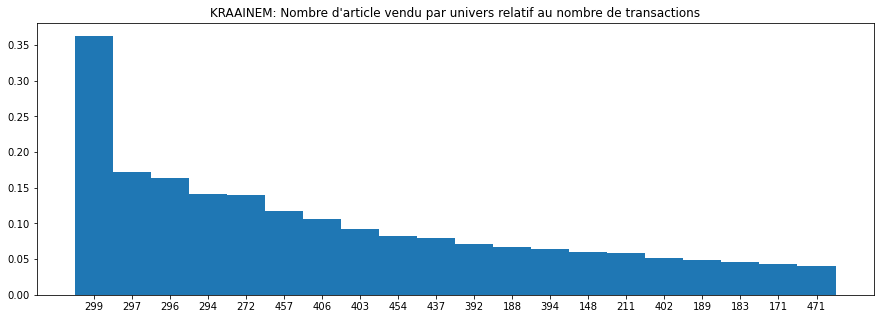

0.0024509803921568627
Running Apriori
78
{117} -> {297} (conf: 0.201, supp: 0.003, lift: 1.433, conv: 1.076)
{294} -> {297} (conf: 0.202, supp: 0.020, lift: 1.444, conv: 1.078)
{443} -> {299} (conf: 0.223, supp: 0.003, lift: 1.464, conv: 1.091)
{452} -> {297} (conf: 0.208, supp: 0.006, lift: 1.482, conv: 1.085)
{294, 297} -> {299} (conf: 0.229, supp: 0.005, lift: 1.507, conv: 1.100)
{13} -> {297} (conf: 0.219, supp: 0.006, lift: 1.567, conv: 1.102)
{174} -> {297} (conf: 0.223, supp: 0.003, lift: 1.595, conv: 1.107)
{22} -> {297} (conf: 0.227, supp: 0.003, lift: 1.621, conv: 1.113)
{171} -> {297} (conf: 0.228, supp: 0.008, lift: 1.630, conv: 1.114)
{183} -> {297} (conf: 0.232, supp: 0.007, lift: 1.656, conv: 1.120)
{225} -> {299} (conf: 0.255, supp: 0.005, lift: 1.673, conv: 1.137)
{169} -> {297} (conf: 0.234, supp: 0.004, lift: 1.674, conv: 1.123)
{298} -> {297} (conf: 0.235, supp: 0.003, lift: 1.674, conv: 1.123)
{294, 299} -> {297} (conf: 0.244, supp: 0.005, lift: 1.741, conv: 1.137)

 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {296, 297} -> {294} (conf: 0.204, supp: 0.004, lift: 2.018, conv: 1.129)
 Univ_KEY         Univ_1                       Univ_2     Univ_3     Univ_4
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS MINI PAINS MINI PAINS
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS      PAINS      PAINS
->
 Univ_KEY         Univ_1                       Univ_2    Univ_3    Univ_4
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES BAGUETTES


Rule :  {462} -> {297} (conf: 0.288, supp: 0.003, lift: 2.055, conv: 1.208)
 Univ_KEY          Univ_1  Univ_2    Univ_3 Univ_4
      462 PRET A CUISINER FROMAGE PATE DURE   BLOC
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {198} -> {299} (conf: 0.313, supp: 0.005, lift: 2.058, conv: 1.235)
 Univ

 Univ_KEY        Univ_1         Univ_2         Univ_3          Univ_4
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD PLATS TRADITION


Rule :  {299, 439} -> {437} (conf: 0.241, supp: 0.003, lift: 3.937, conv: 1.236)
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES
      439       BOISSONS    JUS ZUMEX  JUS ZUMEX 1P  JUS ZUMEX 1P
->
 Univ_KEY         Univ_1       Univ_2       Univ_3       Univ_4
      437 PETIT DEJEUNER CAFE SERVICE CAFE SERVICE CAFE SERVICE


Rule :  {328} -> {454} (conf: 0.254, supp: 0.003, lift: 4.054, conv: 1.256)
 Univ_KEY                     Univ_1 Univ_2   Univ_3   Univ_4
      328 APERITIF   ENTREES   TAPAS  TAPAS FROMAGES FROMAGES
->
 Univ_KEY                     Univ_1                    Univ_2 Univ_3   Univ_4
      454 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS  CHIPS > 1 PERS


Rule :  {27} -> {294} (conf: 0.409, supp: 0.004, lift: 4.057, conv: 1.522)
 Univ_KE

44615
To less data ...
507809


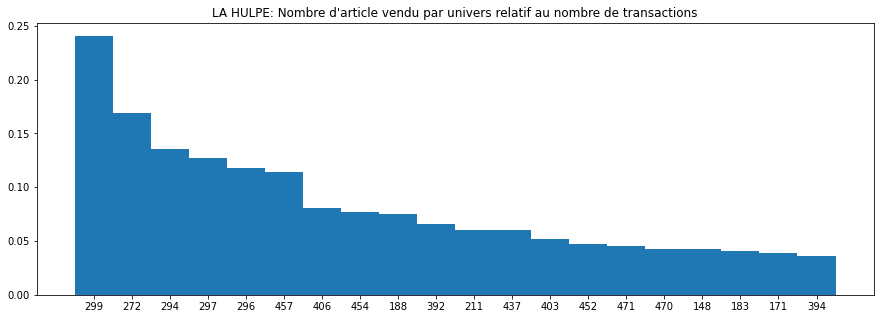

0.0024330900243309003
Running Apriori
40
{231} -> {272} (conf: 0.217, supp: 0.005, lift: 1.509, conv: 1.094)
{126} -> {272} (conf: 0.219, supp: 0.003, lift: 1.518, conv: 1.095)
{296, 297} -> {299} (conf: 0.217, supp: 0.003, lift: 1.777, conv: 1.121)
{225} -> {299} (conf: 0.226, supp: 0.004, lift: 1.853, conv: 1.134)
{296} -> {297} (conf: 0.208, supp: 0.013, lift: 1.965, conv: 1.129)
{22} -> {297} (conf: 0.209, supp: 0.003, lift: 1.966, conv: 1.130)
{83} -> {297} (conf: 0.223, supp: 0.004, lift: 2.098, conv: 1.150)
{74} -> {297} (conf: 0.226, supp: 0.005, lift: 2.135, conv: 1.156)
{472} -> {457} (conf: 0.205, supp: 0.004, lift: 2.192, conv: 1.140)
{198} -> {299} (conf: 0.270, supp: 0.005, lift: 2.213, conv: 1.203)
{62} -> {294} (conf: 0.236, supp: 0.005, lift: 2.256, conv: 1.172)
{296, 299} -> {297} (conf: 0.242, supp: 0.003, lift: 2.282, conv: 1.179)
{18} -> {297} (conf: 0.248, supp: 0.003, lift: 2.338, conv: 1.189)
{22} -> {294} (conf: 0.251, supp: 0.004, lift: 2.392, conv: 1.195)
{47

 Univ_KEY        Univ_1         Univ_2       Univ_3         Univ_4
      406 PRET A MANGER PLATS PREPARES ITALIAN FOOD PLATS ITALIENS


Rule :  {319} -> {454} (conf: 0.226, supp: 0.003, lift: 3.827, conv: 1.216)
 Univ_KEY                     Univ_1                    Univ_2         Univ_3         Univ_4
      319 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS BISCUITS SALES BISCUITS SALES
->
 Univ_KEY                     Univ_1                    Univ_2 Univ_3   Univ_4
      454 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS  CHIPS > 1 PERS


Rule :  {27} -> {294} (conf: 0.436, supp: 0.004, lift: 4.165, conv: 1.588)
 Univ_KEY          Univ_1    Univ_2      Univ_3            Univ_4
       27 PRET A CUISINER BOUCHERIE SPECIALITES AMERICAIN PREPARE
->
 Univ_KEY         Univ_1                       Univ_2    Univ_3    Univ_4
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES BAGUETTES


Rule :  {328} -> {454} (conf: 0.265, supp: 0.002, lift: 4.486, conv: 1.281)
 Un

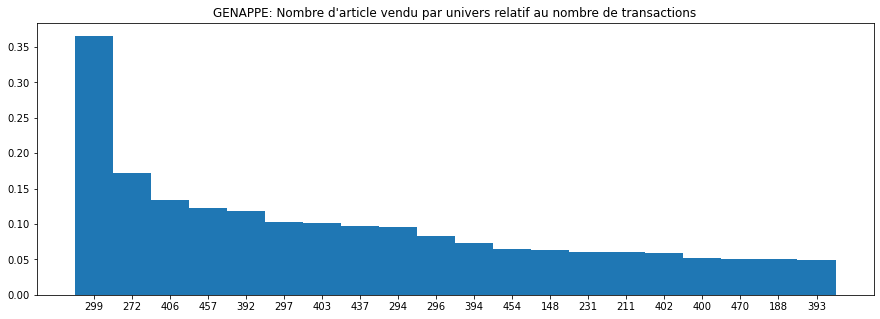

0.0024390243902439024
Running Apriori
50
{303} -> {299} (conf: 0.211, supp: 0.002, lift: 1.280, conv: 1.059)
{188} -> {272} (conf: 0.206, supp: 0.008, lift: 1.422, conv: 1.077)
{225} -> {299} (conf: 0.259, supp: 0.007, lift: 1.570, conv: 1.127)
{296} -> {299} (conf: 0.262, supp: 0.011, lift: 1.591, conv: 1.132)
{311} -> {272} (conf: 0.253, supp: 0.003, lift: 1.746, conv: 1.144)
{296, 297} -> {299} (conf: 0.295, supp: 0.003, lift: 1.786, conv: 1.184)
{231} -> {272} (conf: 0.268, supp: 0.013, lift: 1.855, conv: 1.169)
{231, 299} -> {272} (conf: 0.273, supp: 0.003, lift: 1.885, conv: 1.176)
{129} -> {457} (conf: 0.209, supp: 0.004, lift: 2.061, conv: 1.136)
{198} -> {299} (conf: 0.365, supp: 0.008, lift: 2.212, conv: 1.315)
{402} -> {406} (conf: 0.210, supp: 0.009, lift: 2.270, conv: 1.149)
{437} -> {299} (conf: 0.393, supp: 0.029, lift: 2.381, conv: 1.375)
{272, 437} -> {299} (conf: 0.404, supp: 0.003, lift: 2.447, conv: 1.400)
{412} -> {406} (conf: 0.226, supp: 0.007, lift: 2.450, conv:

 Univ_KEY          Univ_1    Univ_2 Univ_3 Univ_4
       22 PRET A CUISINER BOUCHERIE  BOEUF  BOEUF
->
 Univ_KEY         Univ_1                       Univ_2    Univ_3    Univ_4
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES BAGUETTES


Rule :  {299, 439} -> {437} (conf: 0.257, supp: 0.005, lift: 3.486, conv: 1.246)
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES
      439       BOISSONS    JUS ZUMEX  JUS ZUMEX 1P  JUS ZUMEX 1P
->
 Univ_KEY         Univ_1       Univ_2       Univ_3       Univ_4
      437 PETIT DEJEUNER CAFE SERVICE CAFE SERVICE CAFE SERVICE


Rule :  {271} -> {272} (conf: 0.514, supp: 0.005, lift: 3.548, conv: 1.758)
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      271 TABACS   PRESSE TABAC   ACCESSOIRE TABAC   ACCESSOIRE TABAC   ACCESSOIRE
->
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      2

299777


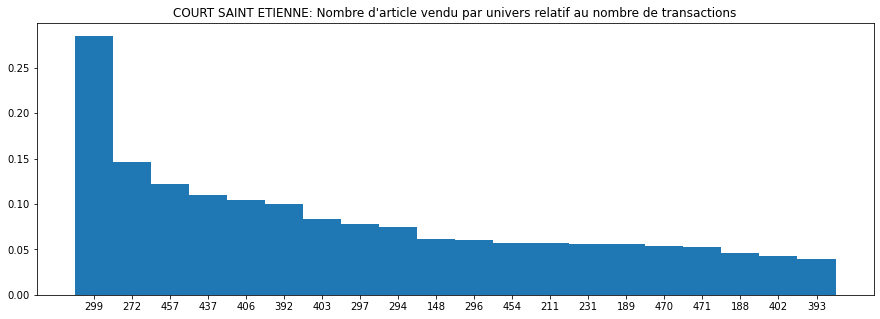

0.0024390243902439024
Running Apriori
28
{225} -> {299} (conf: 0.203, supp: 0.003, lift: 1.467, conv: 1.081)
{296} -> {299} (conf: 0.256, supp: 0.007, lift: 1.848, conv: 1.158)
{452} -> {457} (conf: 0.210, supp: 0.003, lift: 2.036, conv: 1.135)
{198} -> {299} (conf: 0.293, supp: 0.007, lift: 2.116, conv: 1.219)
{437} -> {299} (conf: 0.307, supp: 0.025, lift: 2.216, conv: 1.243)
{402} -> {406} (conf: 0.207, supp: 0.007, lift: 2.795, conv: 1.168)
{57} -> {406} (conf: 0.219, supp: 0.003, lift: 2.958, conv: 1.186)
{301} -> {299} (conf: 0.422, supp: 0.005, lift: 3.050, conv: 1.491)
{412} -> {406} (conf: 0.226, supp: 0.006, lift: 3.053, conv: 1.196)
{439} -> {299} (conf: 0.436, supp: 0.012, lift: 3.147, conv: 1.527)
{296} -> {297} (conf: 0.204, supp: 0.006, lift: 3.244, conv: 1.178)
{403} -> {406} (conf: 0.245, supp: 0.014, lift: 3.310, conv: 1.226)
{408} -> {406} (conf: 0.246, supp: 0.002, lift: 3.325, conv: 1.228)
{299, 439} -> {437} (conf: 0.295, supp: 0.003, lift: 3.568, conv: 1.301)
{27

133096
To less data ...
429819


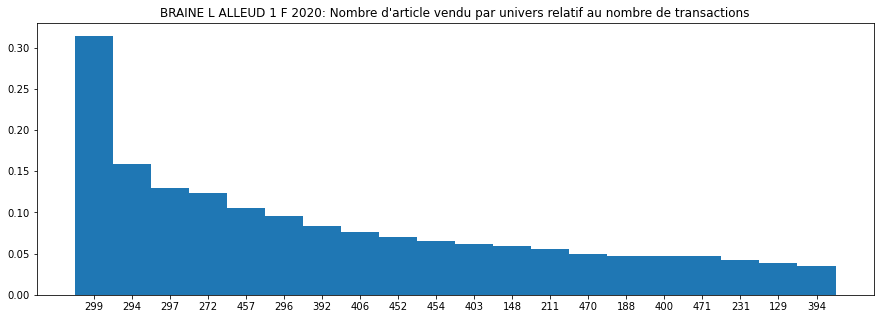

0.0024630541871921183
Running Apriori
41
{394} -> {299} (conf: 0.209, supp: 0.005, lift: 1.214, conv: 1.046)
{298} -> {299} (conf: 0.246, supp: 0.004, lift: 1.431, conv: 1.098)
{294, 296} -> {299} (conf: 0.264, supp: 0.003, lift: 1.538, conv: 1.126)
{296, 297} -> {294} (conf: 0.202, supp: 0.002, lift: 1.542, conv: 1.089)
{225} -> {299} (conf: 0.274, supp: 0.004, lift: 1.594, conv: 1.140)
{13} -> {294} (conf: 0.227, supp: 0.004, lift: 1.726, conv: 1.123)
{296} -> {299} (conf: 0.302, supp: 0.019, lift: 1.755, conv: 1.186)
{294, 296} -> {297} (conf: 0.204, supp: 0.002, lift: 1.821, conv: 1.115)
{296, 299} -> {297} (conf: 0.209, supp: 0.004, lift: 1.870, conv: 1.123)
{296, 297} -> {299} (conf: 0.326, supp: 0.004, lift: 1.898, conv: 1.229)
{74} -> {297} (conf: 0.220, supp: 0.006, lift: 1.963, conv: 1.138)
{62} -> {294} (conf: 0.260, supp: 0.005, lift: 1.981, conv: 1.174)
{52} -> {297} (conf: 0.237, supp: 0.003, lift: 2.122, conv: 1.164)
{18} -> {297} (conf: 0.238, supp: 0.003, lift: 2.129, 

 Univ_KEY          Univ_1  Univ_2     Univ_3     Univ_4
       52 PRET A CUISINER FROMAGE PATE MOLLE PATE MOLLE
->
 Univ_KEY         Univ_1                       Univ_2    Univ_3    Univ_4
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES BAGUETTES


Rule :  {298} -> {296} (conf: 0.211, supp: 0.003, lift: 3.312, conv: 1.187)
 Univ_KEY         Univ_1                       Univ_2            Univ_3            Univ_4
      298 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS PETITES BAGUETTES PETITES BAGUETTES
->
 Univ_KEY         Univ_1                       Univ_2     Univ_3     Univ_4
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS MINI PAINS MINI PAINS


Rule :  {297, 299} -> {296} (conf: 0.216, supp: 0.004, lift: 3.389, conv: 1.195)
 Univ_KEY         Univ_1                       Univ_2        Univ_3        Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS         PAINS         PAINS
      299 PETIT DEJEUNER                 VIENNOISERIE VIENNOISERIES VIENNOISE

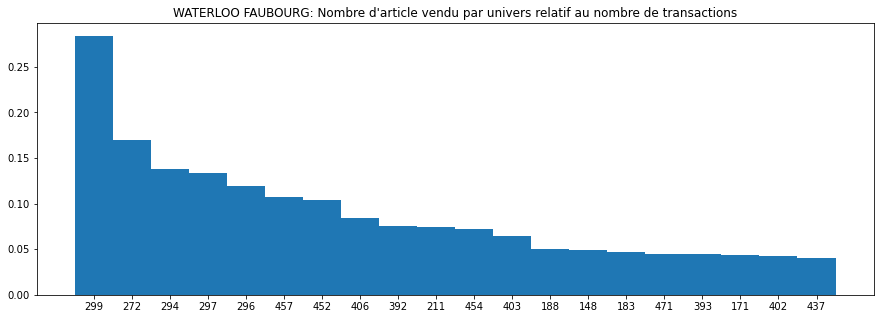

0.0024330900243309003
Running Apriori
120
{188} -> {272} (conf: 0.203, supp: 0.007, lift: 1.365, conv: 1.068)
{297, 452} -> {299} (conf: 0.204, supp: 0.003, lift: 1.384, conv: 1.071)
{294, 297} -> {299} (conf: 0.207, supp: 0.003, lift: 1.405, conv: 1.075)
{294, 452} -> {299} (conf: 0.208, supp: 0.003, lift: 1.413, conv: 1.077)
{231} -> {272} (conf: 0.233, supp: 0.007, lift: 1.560, conv: 1.109)
{225} -> {299} (conf: 0.257, supp: 0.006, lift: 1.745, conv: 1.147)
{294, 299} -> {297} (conf: 0.202, supp: 0.003, lift: 1.798, conv: 1.112)
{299, 452} -> {297} (conf: 0.216, supp: 0.003, lift: 1.927, conv: 1.133)
{299, 452} -> {294} (conf: 0.204, supp: 0.003, lift: 1.933, conv: 1.124)
{296} -> {297} (conf: 0.218, supp: 0.015, lift: 1.939, conv: 1.135)
{294, 296} -> {297} (conf: 0.222, supp: 0.003, lift: 1.978, conv: 1.141)
{303} -> {297} (conf: 0.223, supp: 0.004, lift: 1.990, conv: 1.143)
{74} -> {297} (conf: 0.232, supp: 0.005, lift: 2.063, conv: 1.155)
{360} -> {452} (conf: 0.201, supp: 0.004

 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {294, 296} -> {299} (conf: 0.333, supp: 0.004, lift: 2.263, conv: 1.278)
 Univ_KEY         Univ_1                       Univ_2     Univ_3     Univ_4
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  BAGUETTES  BAGUETTES
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS MINI PAINS MINI PAINS
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {475} -> {294} (conf: 0.240, supp: 0.006, lift: 2.279, conv: 1.178)
 Univ_KEY          Univ_1  Univ_2    Univ_3   Univ_4
      475 PRET A CUISINER FROMAGE PATE DURE TRANCHES
->
 Univ_KEY         Univ_1                       Univ_2    Univ_3    Univ_4
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES BAGUETTES


Rule :  {473} -> {452} (conf: 0.223, supp: 0.003, lift: 2.304, conv: 1.162)
 Univ

 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {62} -> {452} (conf: 0.263, supp: 0.006, lift: 2.713, conv: 1.225)
 Univ_KEY          Univ_1      Univ_2  Univ_3        Univ_4
       62 PRET A CUISINER CHARCUTERIE JAMBONS JAMBONS CUITS
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {134} -> {452} (conf: 0.263, supp: 0.002, lift: 2.714, conv: 1.225)
 Univ_KEY  Univ_1        Univ_2        Univ_3        Univ_4
      134 DESSERT DESSERT FRAIS YAOURT FRUITE YAOURT FRUITE
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {169} -> {452} (conf: 0.263, 

 Univ_KEY        Univ_1         Univ_2        Univ_3          Univ_4
      408 PRET A MANGER PLATS PREPARES JAPANESE FOOD PLATS JAPONNAIS
->
 Univ_KEY        Univ_1         Univ_2       Univ_3         Univ_4
      406 PRET A MANGER PLATS PREPARES ITALIAN FOOD PLATS ITALIENS


Rule :  {287} -> {452} (conf: 0.317, supp: 0.003, lift: 3.270, conv: 1.322)
 Univ_KEY         Univ_1                  Univ_2   Univ_3   Univ_4
      287 PETIT DEJEUNER TARTINABLES ET CEREALES CEREALES CEREALES
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {74} -> {296} (conf: 0.229, supp: 0.005, lift: 3.368, conv: 1.209)
 Univ_KEY          Univ_1 Univ_2 Univ_3 Univ_4
       74 PRET A CUISINER SPREAD SPREAD SPREAD
->
 Univ_KEY         Univ_1                       Univ_2     Univ_3     Univ_4
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQ

 Univ_KEY        Univ_1         Univ_2        Univ_3          Univ_4
      408 PRET A MANGER PLATS PREPARES JAPANESE FOOD PLATS JAPONNAIS
->
 Univ_KEY        Univ_1         Univ_2       Univ_3       Univ_4
      402 PRET A MANGER PLATS PREPARES CHINESE FOOD CHINESE FOOD


Rule :  {56} -> {183} (conf: 0.370, supp: 0.003, lift: 11.489, conv: 1.536)
 Univ_KEY          Univ_1  Univ_2     Univ_3     Univ_4
       56 PRET A CUISINER FROMAGE MOZZARELLA MOZZARELLA
->
 Univ_KEY           Univ_1  Univ_2         Univ_3 Univ_4
      183 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES FRUITS


Rule :  {475} -> {62} (conf: 0.257, supp: 0.006, lift: 11.605, conv: 1.315)
 Univ_KEY          Univ_1  Univ_2    Univ_3   Univ_4
      475 PRET A CUISINER FROMAGE PATE DURE TRANCHES
->
 Univ_KEY          Univ_1      Univ_2  Univ_3        Univ_4
       62 PRET A CUISINER CHARCUTERIE JAMBONS JAMBONS CUITS


Rule :  {62} -> {475} (conf: 0.278, supp: 0.006, lift: 11.605, conv: 1.352)
 Univ_KEY          Univ_1      Univ_2

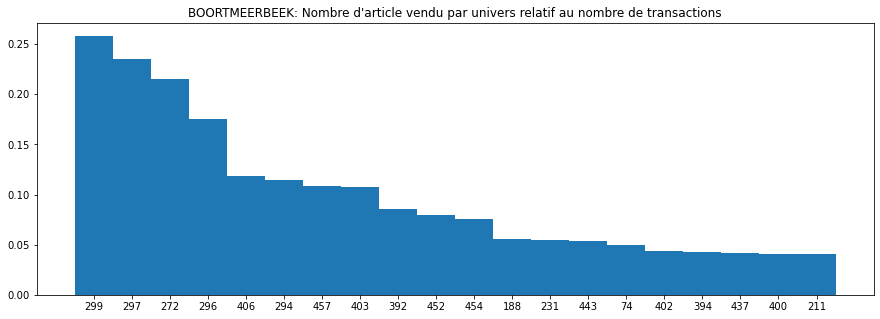

0.0024390243902439024
Running Apriori
143
{461} -> {297} (conf: 0.203, supp: 0.003, lift: 1.077, conv: 1.018)
{439} -> {297} (conf: 0.209, supp: 0.006, lift: 1.105, conv: 1.025)
{452, 457} -> {297} (conf: 0.218, supp: 0.003, lift: 1.156, conv: 1.038)
{250} -> {272} (conf: 0.215, supp: 0.003, lift: 1.171, conv: 1.040)
{406, 452} -> {297} (conf: 0.222, supp: 0.003, lift: 1.176, conv: 1.043)
{299} -> {297} (conf: 0.223, supp: 0.030, lift: 1.180, conv: 1.044)
{147} -> {297} (conf: 0.225, supp: 0.004, lift: 1.190, conv: 1.046)
{299, 439} -> {297} (conf: 0.226, supp: 0.003, lift: 1.197, conv: 1.048)
{403, 452} -> {297} (conf: 0.228, supp: 0.003, lift: 1.210, conv: 1.051)
{294} -> {297} (conf: 0.235, supp: 0.021, lift: 1.244, conv: 1.060)
{272, 452} -> {297} (conf: 0.235, supp: 0.003, lift: 1.247, conv: 1.061)
{298} -> {297} (conf: 0.243, supp: 0.005, lift: 1.287, conv: 1.071)
{303} -> {297} (conf: 0.245, supp: 0.003, lift: 1.298, conv: 1.075)
{452} -> {297} (conf: 0.254, supp: 0.019, lift: 1

 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {83} -> {297} (conf: 0.313, supp: 0.005, lift: 1.657, conv: 1.180)
 Univ_KEY          Univ_1 Univ_2 Univ_3 Univ_4
       83 PRET A CUISINER  OEUFS  OEUFS  OEUFS
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {297, 452} -> {299} (conf: 0.227, supp: 0.004, lift: 1.681, conv: 1.119)
 Univ_KEY         Univ_1                       Univ_2                       Univ_3                       Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS                        PAINS                        PAINS
      452       ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


 Univ_KEY   Univ_1      Univ_2 Univ_3 Univ_4
      457 BOISSONS SOFT DRINKS   SODA  COLAS


Rule :  {297, 475} -> {296} (conf: 0.259, supp: 0.003, lift: 2.565, conv: 1.214)
 Univ_KEY          Univ_1                       Univ_2    Univ_3   Univ_4
      297  PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS     PAINS    PAINS
      475 PRET A CUISINER                      FROMAGE PATE DURE TRANCHES
->
 Univ_KEY         Univ_1                       Univ_2     Univ_3     Univ_4
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS MINI PAINS MINI PAINS


Rule :  {62, 475} -> {297} (conf: 0.490, supp: 0.003, lift: 2.598, conv: 1.592)
 Univ_KEY          Univ_1      Univ_2    Univ_3        Univ_4
       62 PRET A CUISINER CHARCUTERIE   JAMBONS JAMBONS CUITS
      475 PRET A CUISINER     FROMAGE PATE DURE      TRANCHES
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {475} -> {296} (conf: 0.263, supp

 Univ_KEY          Univ_1      Univ_2   Univ_3   Univ_4
       69 PRET A CUISINER CHARCUTERIE VOLAILLE VOLAILLE
->
 Univ_KEY         Univ_1                       Univ_2     Univ_3     Univ_4
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS MINI PAINS MINI PAINS


Rule :  {27} -> {296} (conf: 0.292, supp: 0.004, lift: 2.885, conv: 1.269)
 Univ_KEY          Univ_1    Univ_2      Univ_3            Univ_4
       27 PRET A CUISINER BOUCHERIE SPECIALITES AMERICAIN PREPARE
->
 Univ_KEY         Univ_1                       Univ_2     Univ_3     Univ_4
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS MINI PAINS MINI PAINS


Rule :  {402} -> {406} (conf: 0.231, supp: 0.008, lift: 2.890, conv: 1.196)
 Univ_KEY        Univ_1         Univ_2       Univ_3       Univ_4
      402 PRET A MANGER PLATS PREPARES CHINESE FOOD CHINESE FOOD
->
 Univ_KEY        Univ_1         Univ_2       Univ_3         Univ_4
      406 PRET A MANGER PLATS PREPARES ITALIAN FOOD PLATS ITALIENS


Rule :  {74, 297} -> {

 Univ_KEY         Univ_1                       Univ_2       Univ_3         Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS        PAINS          PAINS
      406  PRET A MANGER               PLATS PREPARES ITALIAN FOOD PLATS ITALIENS
->
 Univ_KEY        Univ_1         Univ_2         Univ_3          Univ_4
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD PLATS TRADITION


Rule :  {461} -> {454} (conf: 0.232, supp: 0.003, lift: 4.197, conv: 1.231)
 Univ_KEY                     Univ_1 Univ_2                  Univ_3                         Univ_4
      461 APERITIF   ENTREES   TAPAS  TAPAS CHARCUTERIE  SAUCISSONS PETITS SAUCISSONS (MINI/TRANC)
->
 Univ_KEY                     Univ_1                    Univ_2 Univ_3   Univ_4
      454 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS  CHIPS > 1 PERS


Rule :  {402, 406} -> {403} (conf: 0.319, supp: 0.002, lift: 4.467, conv: 1.364)
 Univ_KEY        Univ_1         Univ_2       Univ_3         Univ_4
      402 PRET A MANGER 

371447


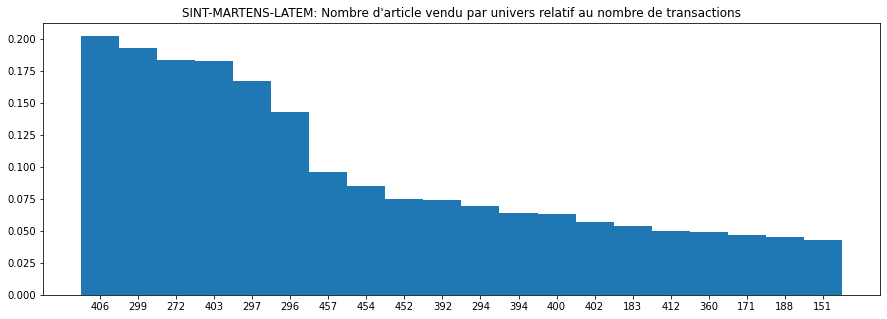

0.002421307506053269
Running Apriori
98
{452, 457} -> {272} (conf: 0.226, supp: 0.002, lift: 1.474, conv: 1.094)
{403, 452} -> {297} (conf: 0.201, supp: 0.003, lift: 1.487, conv: 1.082)
{151} -> {406} (conf: 0.201, supp: 0.006, lift: 1.492, conv: 1.083)
{452} -> {297} (conf: 0.202, supp: 0.014, lift: 1.495, conv: 1.084)
{250} -> {272} (conf: 0.233, supp: 0.005, lift: 1.521, conv: 1.104)
{13} -> {297} (conf: 0.207, supp: 0.006, lift: 1.533, conv: 1.091)
{188} -> {272} (conf: 0.239, supp: 0.008, lift: 1.560, conv: 1.113)
{294} -> {297} (conf: 0.214, supp: 0.012, lift: 1.584, conv: 1.100)
{303} -> {297} (conf: 0.222, supp: 0.004, lift: 1.644, conv: 1.112)
{183} -> {297} (conf: 0.228, supp: 0.009, lift: 1.688, conv: 1.120)
{171} -> {297} (conf: 0.230, supp: 0.008, lift: 1.704, conv: 1.123)
{169} -> {297} (conf: 0.231, supp: 0.004, lift: 1.714, conv: 1.125)
{22} -> {297} (conf: 0.233, supp: 0.004, lift: 1.731, conv: 1.129)
{133} -> {297} (conf: 0.234, supp: 0.003, lift: 1.733, conv: 1.129)


 Univ_KEY   Univ_1    Univ_2        Univ_3        Univ_4
      438 BOISSONS JUS ZUMEX JUS ZUMEX >1P JUS ZUMEX >1P
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {402} -> {406} (conf: 0.276, supp: 0.012, lift: 2.045, conv: 1.194)
 Univ_KEY        Univ_1         Univ_2       Univ_3       Univ_4
      402 PRET A MANGER PLATS PREPARES CHINESE FOOD CHINESE FOOD
->
 Univ_KEY        Univ_1         Univ_2       Univ_3         Univ_4
      406 PRET A MANGER PLATS PREPARES ITALIAN FOOD PLATS ITALIENS


Rule :  {406} -> {403} (conf: 0.244, supp: 0.033, lift: 2.058, conv: 1.166)
 Univ_KEY        Univ_1         Univ_2       Univ_3         Univ_4
      406 PRET A MANGER PLATS PREPARES ITALIAN FOOD PLATS ITALIENS
->
 Univ_KEY        Univ_1         Univ_2         Univ_3          Univ_4
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD PLATS TRADITION


Rule :  {403} -> {406} (conf: 0.277, supp: 0.

 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {403, 454} -> {406} (conf: 0.345, supp: 0.003, lift: 2.560, conv: 1.321)
 Univ_KEY                     Univ_1                    Univ_2         Univ_3          Univ_4
      403              PRET A MANGER            PLATS PREPARES TRADITION FOOD PLATS TRADITION
      454 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS          CHIPS        > 1 PERS
->
 Univ_KEY        Univ_1         Univ_2       Univ_3         Univ_4
      406 PRET A MANGER PLATS PREPARES ITALIAN FOOD PLATS ITALIENS


Rule :  {403, 452} -> {406} (conf: 0.359, supp: 0.005, lift: 2.666, conv: 1.350)
 Univ_KEY        Univ_1                       Univ_2                       Univ_3                       Univ_4
      403 PRET A MANGER               PLATS PREPARES               TRADITION FOOD              PLATS TRADITION
      452      ECONOMAT ARTICLES DESTINES A LA VENTE ARTI

 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {412} -> {402} (conf: 0.209, supp: 0.008, lift: 4.635, conv: 1.207)
 Univ_KEY        Univ_1         Univ_2    Univ_3    Univ_4
      412 PRET A MANGER PLATS PREPARES THAI FOOD THAI FOOD
->
 Univ_KEY        Univ_1         Univ_2       Univ_3       Univ_4
      402 PRET A MANGER PLATS PREPARES CHINESE FOOD CHINESE FOOD


Rule :  {321} -> {454} (conf: 0.286, supp: 0.004, lift: 4.658, conv: 1.315)
 Univ_KEY                     Univ_1                    Univ_2             Univ_3             Univ_4
      321 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS CACAHUETES  AUTRES CACAHUETES  AUTRES
->
 Univ_KEY                     Univ_1                    Univ_2 Univ_3   Univ_4
      454 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS  CHIPS > 1 PERS


Rule :  {319} -> {454} (conf: 0.289, supp: 0.004, lift: 4.699, conv: 1.320)
 Univ_KEY           

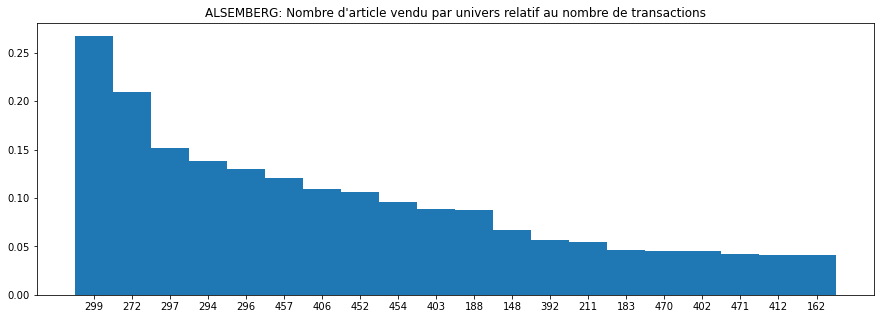

0.0024390243902439024
Running Apriori
153
{452, 457} -> {272} (conf: 0.213, supp: 0.004, lift: 1.173, conv: 1.040)
{299, 457} -> {272} (conf: 0.214, supp: 0.003, lift: 1.180, conv: 1.042)
{472} -> {272} (conf: 0.223, supp: 0.003, lift: 1.227, conv: 1.053)
{126} -> {272} (conf: 0.248, supp: 0.004, lift: 1.364, conv: 1.088)
{236} -> {272} (conf: 0.260, supp: 0.003, lift: 1.428, conv: 1.105)
{294, 452} -> {299} (conf: 0.200, supp: 0.003, lift: 1.499, conv: 1.083)
{188} -> {272} (conf: 0.279, supp: 0.017, lift: 1.533, conv: 1.134)
{294, 299} -> {297} (conf: 0.210, supp: 0.004, lift: 1.651, conv: 1.105)
{303} -> {297} (conf: 0.211, supp: 0.004, lift: 1.660, conv: 1.107)
{219} -> {297} (conf: 0.212, supp: 0.003, lift: 1.662, conv: 1.107)
{406, 452} -> {297} (conf: 0.212, supp: 0.003, lift: 1.666, conv: 1.108)
{169} -> {297} (conf: 0.213, supp: 0.003, lift: 1.675, conv: 1.109)
{171} -> {297} (conf: 0.217, supp: 0.005, lift: 1.704, conv: 1.115)
{188, 452} -> {272} (conf: 0.312, supp: 0.003, li

 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {298} -> {294} (conf: 0.205, supp: 0.005, lift: 1.946, conv: 1.125)
 Univ_KEY         Univ_1                       Univ_2            Univ_3            Univ_4
      298 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS PETITES BAGUETTES PETITES BAGUETTES
->
 Univ_KEY         Univ_1                       Univ_2    Univ_3    Univ_4
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES BAGUETTES


Rule :  {83} -> {297} (conf: 0.249, supp: 0.005, lift: 1.952, conv: 1.161)
 Univ_KEY          Univ_1 Univ_2 Univ_3 Univ_4
       83 PRET A CUISINER  OEUFS  OEUFS  OEUFS
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {296, 299} -> {294} (conf: 0.207, supp: 0.003, lift: 1.960, conv: 1.128)
 Univ_KEY         Univ_1                       Univ_2        Univ_

 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {462} -> {297} (conf: 0.284, supp: 0.004, lift: 2.234, conv: 1.219)
 Univ_KEY          Univ_1  Univ_2    Univ_3 Univ_4
      462 PRET A CUISINER FROMAGE PATE DURE   BLOC
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {475} -> {294} (conf: 0.238, supp: 0.007, lift: 2.261, conv: 1.174)
 Univ_KEY          Univ_1  Univ_2    Univ_3   Univ_4
      475 PRET A CUISINER FROMAGE PATE DURE TRANCHES
->
 Univ_KEY         Univ_1                       Univ_2    Univ_3    Univ_4
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES BAGUETTES


Rule :  {403, 406} -> {452} (conf: 0.227, supp: 0.004, lift: 2.268, conv: 1.165)
 Univ_KEY        Univ_1         Univ_2         Univ

 Univ_KEY  Univ_1        Univ_2      Univ_3      Univ_4
      144 DESSERT DESSERT FRAIS SPECIALITES SPECIALITES
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {151} -> {452} (conf: 0.245, supp: 0.004, lift: 2.448, conv: 1.192)
 Univ_KEY  Univ_1                  Univ_2       Univ_3       Univ_4
      151 DESSERT SALADES DE FRUITS FRAIS INDIVIDUELLE INDIVIDUELLE
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {303} -> {452} (conf: 0.247, supp: 0.005, lift: 2.466, conv: 1.195)
 Univ_KEY         Univ_1            Univ_2     Univ_3     Univ_4
      303 PETIT DEJEUNER PRODUITS LAITIERS LAITS SECS LAITS SECS
->
 Univ_KEY   Univ_1               

 Univ_KEY                     Univ_1                       Univ_2 Univ_3   Univ_4
      297             PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS    PAINS
      454 APERITIF   ENTREES   TAPAS    BISCUITERIE SALEE  SNACKS  CHIPS > 1 PERS
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {297, 457} -> {452} (conf: 0.303, supp: 0.003, lift: 3.021, conv: 1.291)
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS
      457       BOISSONS                  SOFT DRINKS   SODA  COLAS
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {408} -> {406} (conf: 0.227

 Univ_KEY           Univ_1  Univ_2         Univ_3 Univ_4
      183 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES FRUITS
->
 Univ_KEY          Univ_1        Univ_2  Univ_3  Univ_4
       13 PRET A CUISINER 4 ET 5  GAMME SALADES SALADES


Rule :  {13} -> {183} (conf: 0.257, supp: 0.007, lift: 7.898, conv: 1.303)
 Univ_KEY          Univ_1        Univ_2  Univ_3  Univ_4
       13 PRET A CUISINER 4 ET 5  GAMME SALADES SALADES
->
 Univ_KEY           Univ_1  Univ_2         Univ_3 Univ_4
      183 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES FRUITS


Rule :  {408} -> {412} (conf: 0.260, supp: 0.004, lift: 8.578, conv: 1.311)
 Univ_KEY        Univ_1         Univ_2        Univ_3          Univ_4
      408 PRET A MANGER PLATS PREPARES JAPANESE FOOD PLATS JAPONNAIS
->
 Univ_KEY        Univ_1         Univ_2    Univ_3    Univ_4
      412 PRET A MANGER PLATS PREPARES THAI FOOD THAI FOOD


Rule :  {407} -> {412} (conf: 0.280, supp: 0.003, lift: 9.212, conv: 1.346)
 Univ_KEY        Univ_1         Univ_2      Univ_3

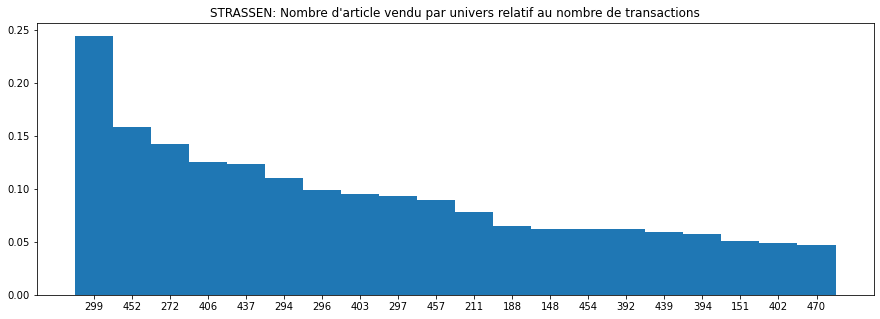

0.0024330900243309003
Running Apriori
149
{148} -> {452} (conf: 0.201, supp: 0.009, lift: 1.366, conv: 1.067)
{297} -> {452} (conf: 0.208, supp: 0.016, lift: 1.415, conv: 1.077)
{220} -> {452} (conf: 0.209, supp: 0.003, lift: 1.421, conv: 1.078)
{296} -> {452} (conf: 0.213, supp: 0.013, lift: 1.449, conv: 1.084)
{163} -> {452} (conf: 0.215, supp: 0.004, lift: 1.464, conv: 1.087)
{471} -> {452} (conf: 0.216, supp: 0.007, lift: 1.466, conv: 1.087)
{225} -> {452} (conf: 0.217, supp: 0.008, lift: 1.477, conv: 1.090)
{457} -> {452} (conf: 0.220, supp: 0.016, lift: 1.497, conv: 1.094)
{470} -> {452} (conf: 0.221, supp: 0.008, lift: 1.501, conv: 1.095)
{296} -> {299} (conf: 0.210, supp: 0.013, lift: 1.537, conv: 1.093)
{298} -> {452} (conf: 0.226, supp: 0.004, lift: 1.538, conv: 1.102)
{188} -> {452} (conf: 0.227, supp: 0.010, lift: 1.541, conv: 1.103)
{297, 452} -> {299} (conf: 0.213, supp: 0.003, lift: 1.555, conv: 1.097)
{406} -> {452} (conf: 0.230, supp: 0.020, lift: 1.564, conv: 1.108)
{

 Univ_KEY        Univ_1  Univ_2        Univ_3 Univ_4
      357 PRET A MANGER SALADES SALADES REPAS  PATES
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {358} -> {452} (conf: 0.256, supp: 0.003, lift: 1.739, conv: 1.146)
 Univ_KEY        Univ_1  Univ_2        Univ_3 Univ_4
      358 PRET A MANGER SALADES SALADES REPAS QUINOA
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {113} -> {452} (conf: 0.257, supp: 0.003, lift: 1.749, conv: 1.148)
 Univ_KEY  Univ_1             Univ_2                 Univ_3                 Univ_4
      113 DESSERT BISCUITERIE SUCREE BISCUITS NUTRITIONNELS BISCUITS NUTRITIONNELS
->
 Univ_KEY   Univ_1               

 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {303} -> {452} (conf: 0.300, supp: 0.004, lift: 2.043, conv: 1.219)
 Univ_KEY         Univ_1            Univ_2     Univ_3     Univ_4
      303 PETIT DEJEUNER PRODUITS LAITIERS LAITS SECS LAITS SECS
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {162} -> {452} (conf: 0.306, supp: 0.008, lift: 2.084, conv: 1.230)
 Univ_KEY   Univ_1   Univ_2 Univ_3 Univ_4
      162 SURGELES DESSERTS GLACES GLACES
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES

 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {62} -> {452} (conf: 0.357, supp: 0.004, lift: 2.428, conv: 1.327)
 Univ_KEY          Univ_1      Univ_2  Univ_3        Univ_4
       62 PRET A CUISINER CHARCUTERIE JAMBONS JAMBONS CUITS
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {300} -> {452} (conf: 0.358, supp: 0.008, lift: 2.437, conv: 1.329)
 Univ_KEY         Univ_1                   Univ_2                   Univ_3                   Univ_4
      300 PETIT DEJEUNER BOULANGERIE PRE EMBALLEE BOULANGERIE PRE EMBALLEE BOULANGERIE PRE EMBALLEE
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A L

 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {439, 452} -> {299} (conf: 0.387, supp: 0.003, lift: 2.827, conv: 1.408)
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      439 BOISSONS                    JUS ZUMEX                 JUS ZUMEX 1P                 JUS ZUMEX 1P
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {296} -> {297} (conf: 0.221, supp: 0.014, lift: 2.831, conv: 1.183)
 Univ_KEY         Univ_1                       Univ_2     Univ_3     Univ_4
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS MINI PAINS MINI PAINS
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BO

 Univ_KEY         Univ_1       Univ_2       Univ_3       Univ_4
      437 PETIT DEJEUNER CAFE SERVICE CAFE SERVICE CAFE SERVICE
      439       BOISSONS    JUS ZUMEX JUS ZUMEX 1P JUS ZUMEX 1P
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {299, 437} -> {439} (conf: 0.255, supp: 0.009, lift: 5.078, conv: 1.275)
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES
      437 PETIT DEJEUNER CAFE SERVICE  CAFE SERVICE  CAFE SERVICE
->
 Univ_KEY   Univ_1    Univ_2       Univ_3       Univ_4
      439 BOISSONS JUS ZUMEX JUS ZUMEX 1P JUS ZUMEX 1P


Rule :  {418} -> {403} (conf: 0.342, supp: 0.003, lift: 5.280, conv: 1.420)
 Univ_KEY        Univ_1         Univ_2              Univ_3  Univ_4
      418 PRET A MANGER PLATS PREPARES COMPOSANTS DE REPAS LEGUMES
->
 Univ_KEY        Univ_1         Univ_2         Univ_3          U

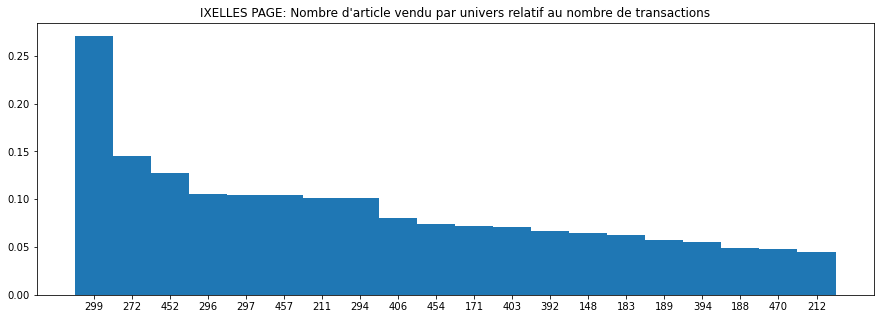

0.0024271844660194173
Running Apriori
128
{277} -> {299} (conf: 0.215, supp: 0.004, lift: 1.544, conv: 1.096)
{296} -> {299} (conf: 0.218, supp: 0.012, lift: 1.567, conv: 1.101)
{225} -> {299} (conf: 0.223, supp: 0.006, lift: 1.601, conv: 1.108)
{211} -> {452} (conf: 0.204, supp: 0.017, lift: 1.705, conv: 1.106)
{443} -> {299} (conf: 0.239, supp: 0.005, lift: 1.717, conv: 1.131)
{360} -> {452} (conf: 0.206, supp: 0.006, lift: 1.721, conv: 1.109)
{189} -> {452} (conf: 0.209, supp: 0.007, lift: 1.745, conv: 1.113)
{162} -> {452} (conf: 0.209, supp: 0.005, lift: 1.747, conv: 1.113)
{147} -> {452} (conf: 0.209, supp: 0.003, lift: 1.748, conv: 1.113)
{231} -> {272} (conf: 0.213, supp: 0.005, lift: 1.751, conv: 1.116)
{246} -> {452} (conf: 0.210, supp: 0.004, lift: 1.753, conv: 1.114)
{403} -> {452} (conf: 0.212, supp: 0.011, lift: 1.773, conv: 1.117)
{193} -> {452} (conf: 0.212, supp: 0.003, lift: 1.774, conv: 1.117)
{463} -> {452} (conf: 0.213, supp: 0.003, lift: 1.777, conv: 1.118)
{294, 

Rule :  {302} -> {452} (conf: 0.228, supp: 0.003, lift: 1.908, conv: 1.141)
 Univ_KEY         Univ_1            Univ_2      Univ_3      Univ_4
      302 PETIT DEJEUNER PRODUITS LAITIERS LAITS FRAIS LAITS FRAIS
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {176} -> {452} (conf: 0.232, supp: 0.004, lift: 1.935, conv: 1.146)
 Univ_KEY           Univ_1 Univ_2 Univ_3 Univ_4
      176 FRUITS   LEGUMES FRUITS VERGER VERGER
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {402} -> {452} (conf: 0.232, supp: 0.008, lift: 1.936, conv: 1.146)
 Univ_KEY        Univ_1         Univ_2       Univ_3       Univ_4
      402 PRET A MANGER PLATS PREPARES CHIN

 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {78} -> {452} (conf: 0.272, supp: 0.004, lift: 2.273, conv: 1.209)
 Univ_KEY          Univ_1      Univ_2 Univ_3 Univ_4
       78 PRET A CUISINER PATES   RIZ  PATES  PATES
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {432} -> {452} (conf: 0.274, supp: 0.002, lift: 2.288, conv: 1.212)
 Univ_KEY                     Univ_1       Univ_2       Univ_3       Univ_4
      432 APERITIF   ENTREES   TAPAS POTAGE FRAIS GRAND FORMAT CHAUD >300ML
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTIC

 Univ_KEY          Univ_1      Univ_2  Univ_3        Univ_4
       62 PRET A CUISINER CHARCUTERIE JAMBONS JAMBONS CUITS
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {171, 183} -> {452} (conf: 0.324, supp: 0.003, lift: 2.710, conv: 1.303)
 Univ_KEY           Univ_1  Univ_2         Univ_3   Univ_4
      171 FRUITS   LEGUMES  FRUITS       EXOTIQUE EXOTIQUE
      183 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES   FRUITS
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {437} -> {299} (conf: 0.378, supp: 0.011, lift: 2.717, conv: 1.384)
 Univ_KEY         Univ_1       Univ_2       Univ_3       Univ_4
      437 PETIT DEJEUNER CAFE SERVICE CAFE SERVICE CAFE SERVICE
->
 Univ_KEY         Univ_1       Univ_2        Univ_3      

 Univ_KEY           Univ_1                       Univ_2                       Univ_3                       Univ_4
      183 FRUITS   LEGUMES                      LEGUMES               AUTRES LEGUMES                       FRUITS
      452         ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE
->
 Univ_KEY           Univ_1 Univ_2   Univ_3   Univ_4
      171 FRUITS   LEGUMES FRUITS EXOTIQUE EXOTIQUE


Rule :  {169} -> {171} (conf: 0.277, supp: 0.007, lift: 5.037, conv: 1.307)
 Univ_KEY           Univ_1 Univ_2  Univ_3  Univ_4
      169 FRUITS   LEGUMES FRUITS AGRUMES AGRUMES
->
 Univ_KEY           Univ_1 Univ_2   Univ_3   Univ_4
      171 FRUITS   LEGUMES FRUITS EXOTIQUE EXOTIQUE


Rule :  {171, 452} -> {183} (conf: 0.240, supp: 0.003, lift: 5.461, conv: 1.258)
 Univ_KEY           Univ_1                       Univ_2                       Univ_3                       Univ_4
      171 FRUITS   LEGUMES                       FRUITS              

97472
To less data ...
40938
To less data ...
618
To less data ...
22754
To less data ...
674247


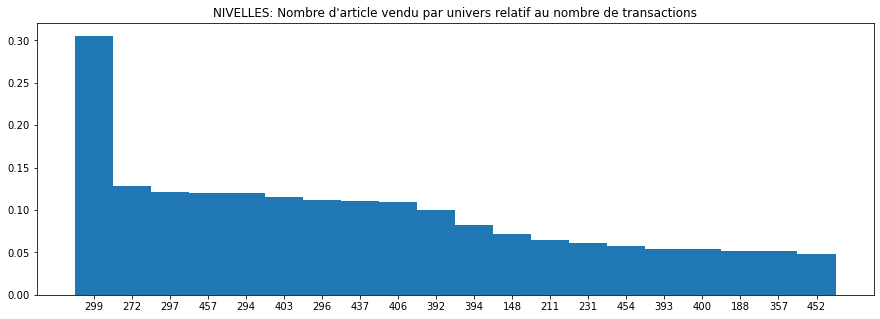

0.0024271844660194173
Running Apriori
48
{296} -> {299} (conf: 0.218, supp: 0.014, lift: 1.403, conv: 1.080)
{225} -> {299} (conf: 0.231, supp: 0.005, lift: 1.483, conv: 1.098)
{294, 296} -> {299} (conf: 0.246, supp: 0.003, lift: 1.580, conv: 1.120)
{296, 297} -> {299} (conf: 0.263, supp: 0.003, lift: 1.695, conv: 1.147)
{231} -> {272} (conf: 0.201, supp: 0.010, lift: 1.851, conv: 1.116)
{311} -> {272} (conf: 0.223, supp: 0.003, lift: 2.053, conv: 1.147)
{13} -> {297} (conf: 0.206, supp: 0.003, lift: 2.069, conv: 1.134)
{294, 299} -> {297} (conf: 0.209, supp: 0.003, lift: 2.093, conv: 1.138)
{198} -> {299} (conf: 0.335, supp: 0.005, lift: 2.156, conv: 1.270)
{183} -> {297} (conf: 0.219, supp: 0.004, lift: 2.201, conv: 1.153)
{22} -> {297} (conf: 0.237, supp: 0.003, lift: 2.379, conv: 1.180)
{437} -> {299} (conf: 0.373, supp: 0.030, lift: 2.396, conv: 1.346)
{296, 299} -> {297} (conf: 0.240, supp: 0.003, lift: 2.408, conv: 1.185)
{296, 297} -> {294} (conf: 0.210, supp: 0.003, lift: 2.41

 Univ_KEY   Univ_1    Univ_2       Univ_3       Univ_4
      439 BOISSONS JUS ZUMEX JUS ZUMEX 1P JUS ZUMEX 1P
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {294, 299} -> {296} (conf: 0.203, supp: 0.003, lift: 3.274, conv: 1.177)
 Univ_KEY         Univ_1                       Univ_2        Univ_3        Univ_4
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS     BAGUETTES     BAGUETTES
      299 PETIT DEJEUNER                 VIENNOISERIE VIENNOISERIES VIENNOISERIES
->
 Univ_KEY         Univ_1                       Univ_2     Univ_3     Univ_4
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS MINI PAINS MINI PAINS


Rule :  {297, 299} -> {296} (conf: 0.210, supp: 0.003, lift: 3.387, conv: 1.188)
 Univ_KEY         Univ_1                       Univ_2        Univ_3        Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS         PAINS         PAINS
      299 PETIT DEJEUNER

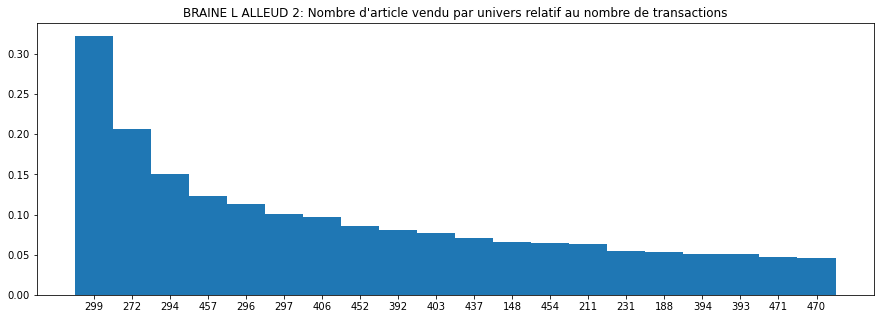

0.0024154589371980675
Running Apriori
79
{250} -> {272} (conf: 0.202, supp: 0.005, lift: 1.147, conv: 1.033)
{198} -> {272} (conf: 0.205, supp: 0.003, lift: 1.163, conv: 1.036)
{452, 457} -> {272} (conf: 0.209, supp: 0.003, lift: 1.182, conv: 1.041)
{303} -> {299} (conf: 0.202, supp: 0.003, lift: 1.253, conv: 1.051)
{294, 297} -> {299} (conf: 0.203, supp: 0.003, lift: 1.257, conv: 1.052)
{188} -> {272} (conf: 0.228, supp: 0.009, lift: 1.294, conv: 1.067)
{294, 452} -> {299} (conf: 0.219, supp: 0.003, lift: 1.357, conv: 1.074)
{231} -> {272} (conf: 0.282, supp: 0.012, lift: 1.597, conv: 1.147)
{311} -> {272} (conf: 0.293, supp: 0.003, lift: 1.659, conv: 1.165)
{220} -> {299} (conf: 0.273, supp: 0.003, lift: 1.695, conv: 1.154)
{225} -> {299} (conf: 0.282, supp: 0.004, lift: 1.749, conv: 1.168)
{296} -> {299} (conf: 0.289, supp: 0.018, lift: 1.795, conv: 1.180)
{294, 296} -> {299} (conf: 0.290, supp: 0.004, lift: 1.801, conv: 1.182)
{216} -> {299} (conf: 0.294, supp: 0.003, lift: 1.822, 

 Univ_KEY          Univ_1 Univ_2 Univ_3 Univ_4
       74 PRET A CUISINER SPREAD SPREAD SPREAD
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {437} -> {299} (conf: 0.390, supp: 0.021, lift: 2.423, conv: 1.376)
 Univ_KEY         Univ_1       Univ_2       Univ_3       Univ_4
      437 PETIT DEJEUNER CAFE SERVICE CAFE SERVICE CAFE SERVICE
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {83} -> {297} (conf: 0.213, supp: 0.003, lift: 2.436, conv: 1.159)
 Univ_KEY          Univ_1 Univ_2 Univ_3 Univ_4
       83 PRET A CUISINER  OEUFS  OEUFS  OEUFS
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {74} -> {452} (conf: 0.211, supp: 0.004, lift: 2.583, conv: 1.164)
 Univ_KEY          Univ_1 Univ_2 Univ_3

 Univ_KEY         Univ_1                       Univ_2        Univ_3        Univ_4
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS     BAGUETTES     BAGUETTES
      299 PETIT DEJEUNER                 VIENNOISERIE VIENNOISERIES VIENNOISERIES
->
 Univ_KEY         Univ_1                       Univ_2     Univ_3     Univ_4
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS MINI PAINS MINI PAINS


Rule :  {408} -> {406} (conf: 0.240, supp: 0.003, lift: 3.463, conv: 1.225)
 Univ_KEY        Univ_1         Univ_2        Univ_3          Univ_4
      408 PRET A MANGER PLATS PREPARES JAPANESE FOOD PLATS JAPONNAIS
->
 Univ_KEY        Univ_1         Univ_2       Univ_3         Univ_4
      406 PRET A MANGER PLATS PREPARES ITALIAN FOOD PLATS ITALIENS


Rule :  {74} -> {296} (conf: 0.215, supp: 0.004, lift: 3.480, conv: 1.195)
 Univ_KEY          Univ_1 Univ_2 Univ_3 Univ_4
       74 PRET A CUISINER SPREAD SPREAD SPREAD
->
 Univ_KEY         Univ_1                       Univ_2     Univ_3     Uni

351105


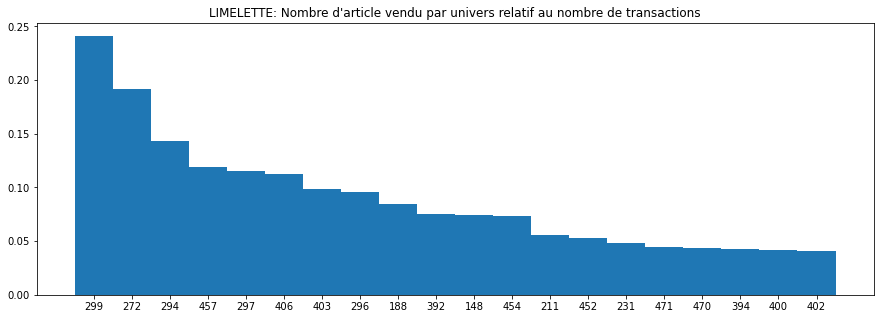

0.0024630541871921183
Running Apriori
42
{188} -> {272} (conf: 0.205, supp: 0.012, lift: 1.263, conv: 1.054)
{311} -> {272} (conf: 0.216, supp: 0.003, lift: 1.330, conv: 1.068)
{394} -> {299} (conf: 0.201, supp: 0.006, lift: 1.450, conv: 1.078)
{231} -> {272} (conf: 0.255, supp: 0.010, lift: 1.569, conv: 1.124)
{296} -> {299} (conf: 0.239, supp: 0.014, lift: 1.722, conv: 1.132)
{294, 296} -> {299} (conf: 0.245, supp: 0.003, lift: 1.764, conv: 1.141)
{296, 297} -> {299} (conf: 0.272, supp: 0.003, lift: 1.963, conv: 1.184)
{13} -> {294} (conf: 0.223, supp: 0.005, lift: 2.002, conv: 1.144)
{296, 299} -> {297} (conf: 0.206, supp: 0.003, lift: 2.081, conv: 1.135)
{74} -> {297} (conf: 0.212, supp: 0.005, lift: 2.137, conv: 1.143)
{225} -> {299} (conf: 0.328, supp: 0.004, lift: 2.361, conv: 1.281)
{83} -> {297} (conf: 0.235, supp: 0.004, lift: 2.372, conv: 1.178)
{62} -> {294} (conf: 0.266, supp: 0.005, lift: 2.385, conv: 1.210)
{52} -> {297} (conf: 0.240, supp: 0.003, lift: 2.418, conv: 1.18

 Univ_KEY          Univ_1 Univ_2 Univ_3 Univ_4
       74 PRET A CUISINER SPREAD SPREAD SPREAD
->
 Univ_KEY         Univ_1                       Univ_2     Univ_3     Univ_4
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS MINI PAINS MINI PAINS


Rule :  {301} -> {299} (conf: 0.517, supp: 0.005, lift: 3.725, conv: 1.783)
 Univ_KEY         Univ_1            Univ_2           Univ_3           Univ_4
      301 PETIT DEJEUNER PRODUITS LAITIERS LAITS CHOCOLATES LAITS CHOCOLATES
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {439} -> {299} (conf: 0.544, supp: 0.012, lift: 3.918, conv: 1.888)
 Univ_KEY   Univ_1    Univ_2       Univ_3       Univ_4
      439 BOISSONS JUS ZUMEX JUS ZUMEX 1P JUS ZUMEX 1P
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {74} -> {294} (conf: 0.451, supp: 0.010, lift: 4.04

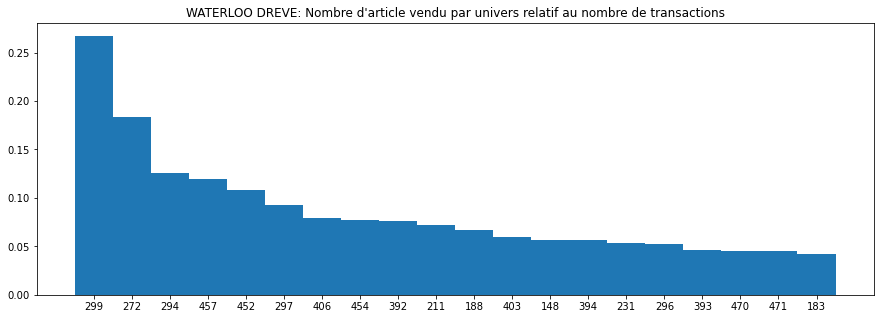

0.0024271844660194173
Running Apriori
87
{188} -> {272} (conf: 0.201, supp: 0.009, lift: 1.290, conv: 1.056)
{250} -> {272} (conf: 0.205, supp: 0.004, lift: 1.317, conv: 1.062)
{231} -> {272} (conf: 0.236, supp: 0.010, lift: 1.514, conv: 1.105)
{297, 452} -> {299} (conf: 0.212, supp: 0.003, lift: 1.522, conv: 1.092)
{294, 452} -> {299} (conf: 0.222, supp: 0.003, lift: 1.595, conv: 1.106)
{296} -> {299} (conf: 0.254, supp: 0.007, lift: 1.830, conv: 1.155)
{225} -> {299} (conf: 0.272, supp: 0.006, lift: 1.957, conv: 1.183)
{402} -> {452} (conf: 0.206, supp: 0.005, lift: 2.013, conv: 1.130)
{121} -> {452} (conf: 0.214, supp: 0.004, lift: 2.090, conv: 1.142)
{294, 297} -> {452} (conf: 0.217, supp: 0.002, lift: 2.125, conv: 1.147)
{412} -> {452} (conf: 0.218, supp: 0.004, lift: 2.132, conv: 1.148)
{409} -> {452} (conf: 0.221, supp: 0.003, lift: 2.162, conv: 1.153)
{162} -> {452} (conf: 0.222, supp: 0.005, lift: 2.171, conv: 1.154)
{438} -> {299} (conf: 0.305, supp: 0.003, lift: 2.196, conv:

 Univ_KEY                     Univ_1 Univ_2                  Univ_3                         Univ_4
      461 APERITIF   ENTREES   TAPAS  TAPAS CHARCUTERIE  SAUCISSONS PETITS SAUCISSONS (MINI/TRANC)
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {151} -> {452} (conf: 0.258, supp: 0.006, lift: 2.524, conv: 1.210)
 Univ_KEY  Univ_1                  Univ_2       Univ_3       Univ_4
      151 DESSERT SALADES DE FRUITS FRAIS INDIVIDUELLE INDIVIDUELLE
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {74} -> {297} (conf: 0.200, supp: 0.004, lift: 2.538, conv: 1.152)
 Univ_KEY          Univ_1 Univ_2 Univ_3 Univ_4
       74 PRET A CUISINER SPREAD S

 Univ_KEY                     Univ_1      Univ_2         Univ_3         Univ_4
      341 APERITIF   ENTREES   TAPAS SAURISSERIE PRODUITS FUMES PRODUITS FUMES
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {62} -> {297} (conf: 0.245, supp: 0.005, lift: 3.112, conv: 1.221)
 Univ_KEY          Univ_1      Univ_2  Univ_3        Univ_4
       62 PRET A CUISINER CHARCUTERIE JAMBONS JAMBONS CUITS
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {454, 457} -> {452} (conf: 0.321, supp: 0.003, lift: 3.136, conv: 1.321)
 Univ_KEY                     Univ_1                    Univ_2 Univ_3   Univ_4
      454 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS  CHIPS > 1 PERS
      457                   BOISSONS              

345985


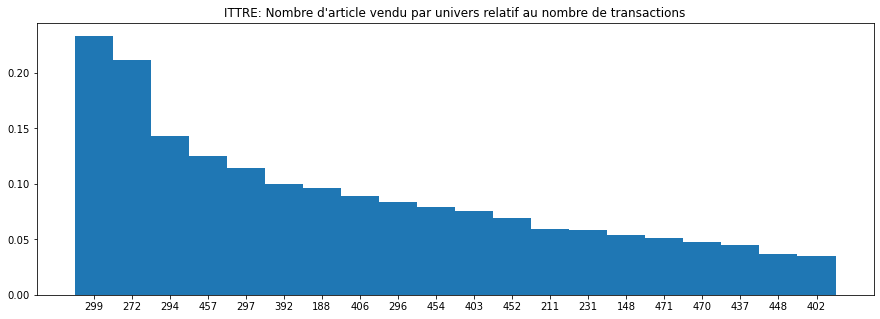

0.0024449877750611247
Running Apriori
66
{250} -> {272} (conf: 0.205, supp: 0.005, lift: 1.122, conv: 1.028)
{452, 457} -> {272} (conf: 0.231, supp: 0.003, lift: 1.264, conv: 1.063)
{126} -> {272} (conf: 0.240, supp: 0.003, lift: 1.313, conv: 1.075)
{311} -> {272} (conf: 0.298, supp: 0.004, lift: 1.632, conv: 1.164)
{231} -> {272} (conf: 0.300, supp: 0.014, lift: 1.643, conv: 1.168)
{296} -> {299} (conf: 0.224, supp: 0.011, lift: 1.810, conv: 1.129)
{13} -> {294} (conf: 0.200, supp: 0.004, lift: 1.871, conv: 1.117)
{297, 299} -> {294} (conf: 0.203, supp: 0.003, lift: 1.892, conv: 1.120)
{225} -> {299} (conf: 0.236, supp: 0.004, lift: 1.910, conv: 1.148)
{18} -> {294} (conf: 0.206, supp: 0.003, lift: 1.924, conv: 1.125)
{296} -> {294} (conf: 0.214, supp: 0.010, lift: 2.002, conv: 1.136)
{296, 297} -> {299} (conf: 0.260, supp: 0.003, lift: 2.098, conv: 1.184)
{83} -> {297} (conf: 0.209, supp: 0.003, lift: 2.163, conv: 1.142)
{296, 297} -> {294} (conf: 0.239, supp: 0.003, lift: 2.231, con

 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {198} -> {299} (conf: 0.287, supp: 0.005, lift: 2.316, conv: 1.228)
 Univ_KEY         Univ_1          Univ_2     Univ_3     Univ_4
      198 PETIT DEJEUNER CAFE THE SUCRES CAFE FROID CAFE FROID
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {18} -> {297} (conf: 0.227, supp: 0.003, lift: 2.352, conv: 1.169)
 Univ_KEY          Univ_1                     Univ_2  Univ_3  Univ_4
       18 PRET A CUISINER BEURRES   MATIERES GRASSES BEURRES BEURRES
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {272, 452} -> {457} (conf: 0.244, supp: 0.003, lift: 2.395, conv: 1.188)
 Univ_KEY          Univ_1                       Univ_2                       Univ_3     

Rule :  {294, 448} -> {297} (conf: 0.979, supp: 0.006, lift: 10.125, conv: 42.436)
 Univ_KEY         Univ_1                       Univ_2                 Univ_3                 Univ_4
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS              BAGUETTES              BAGUETTES
      448       ECONOMAT               ECONOMAT AUTRE FOURNITURE ET MATERIEL FOURNITURE ET MATERIEL
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {299, 448} -> {297} (conf: 0.981, supp: 0.004, lift: 10.148, conv: 47.390)
 Univ_KEY         Univ_1         Univ_2                 Univ_3                 Univ_4
      299 PETIT DEJEUNER   VIENNOISERIE          VIENNOISERIES          VIENNOISERIES
      448       ECONOMAT ECONOMAT AUTRE FOURNITURE ET MATERIEL FOURNITURE ET MATERIEL
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PA

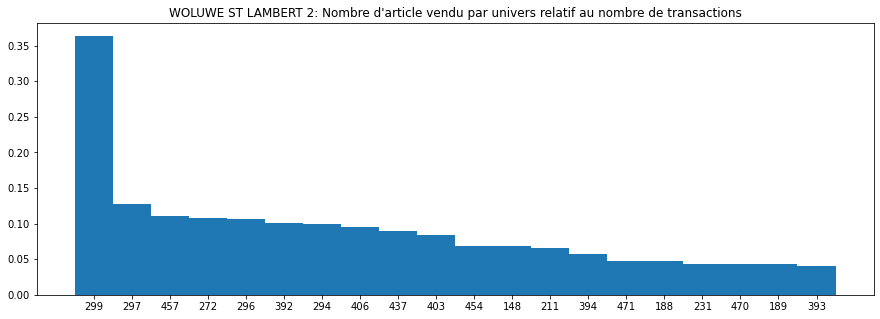

0.0024390243902439024
Running Apriori
46
{147} -> {299} (conf: 0.200, supp: 0.002, lift: 1.162, conv: 1.035)
{231} -> {299} (conf: 0.217, supp: 0.007, lift: 1.258, conv: 1.057)
{294, 297} -> {299} (conf: 0.217, supp: 0.003, lift: 1.260, conv: 1.057)
{225} -> {299} (conf: 0.238, supp: 0.005, lift: 1.382, conv: 1.087)
{296} -> {299} (conf: 0.240, supp: 0.012, lift: 1.390, conv: 1.088)
{298} -> {299} (conf: 0.250, supp: 0.003, lift: 1.451, conv: 1.104)
{443} -> {299} (conf: 0.269, supp: 0.004, lift: 1.563, conv: 1.133)
{220} -> {299} (conf: 0.288, supp: 0.003, lift: 1.668, conv: 1.162)
{296, 297} -> {299} (conf: 0.304, supp: 0.003, lift: 1.761, conv: 1.188)
{277} -> {299} (conf: 0.317, supp: 0.008, lift: 1.839, conv: 1.212)
{169} -> {297} (conf: 0.207, supp: 0.003, lift: 1.949, conv: 1.127)
{303} -> {297} (conf: 0.207, supp: 0.005, lift: 1.955, conv: 1.128)
{296, 299} -> {297} (conf: 0.215, supp: 0.003, lift: 2.030, conv: 1.139)
{183} -> {297} (conf: 0.220, supp: 0.006, lift: 2.071, conv:

 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {18} -> {297} (conf: 0.295, supp: 0.003, lift: 2.787, conv: 1.269)
 Univ_KEY          Univ_1                     Univ_2  Univ_3  Univ_4
       18 PRET A CUISINER BEURRES   MATIERES GRASSES BEURRES BEURRES
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {475} -> {294} (conf: 0.216, supp: 0.004, lift: 2.788, conv: 1.177)
 Univ_KEY          Univ_1  Univ_2    Univ_3   Univ_4
      475 PRET A CUISINER FROMAGE PATE DURE TRANCHES
->
 Univ_KEY         Univ_1                       Univ_2    Univ_3    Univ_4
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES BAGUETTES


Rule :  {439} -> {299} (conf: 0.488, supp: 0.017, lift: 2.828, conv: 1.615)
 Univ_KEY   Univ_1    Univ_2       Univ_3       Univ_4
      439 BOISSONS JUS ZUMEX JUS ZUMEX 1P JUS 

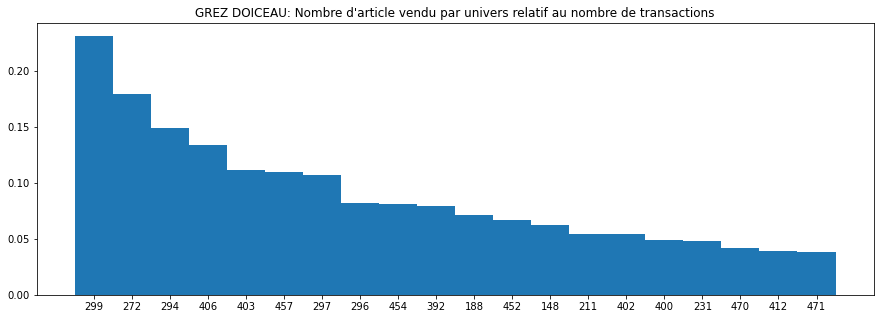

0.0024509803921568627
Running Apriori
56
{188} -> {272} (conf: 0.205, supp: 0.010, lift: 1.349, conv: 1.067)
{210} -> {272} (conf: 0.220, supp: 0.003, lift: 1.450, conv: 1.087)
{231} -> {272} (conf: 0.239, supp: 0.009, lift: 1.579, conv: 1.115)
{311} -> {272} (conf: 0.252, supp: 0.003, lift: 1.662, conv: 1.134)
{298} -> {294} (conf: 0.208, supp: 0.003, lift: 1.770, conv: 1.115)
{296, 299} -> {294} (conf: 0.209, supp: 0.003, lift: 1.778, conv: 1.116)
{225} -> {299} (conf: 0.223, supp: 0.003, lift: 1.823, conv: 1.130)
{13} -> {294} (conf: 0.217, supp: 0.004, lift: 1.840, conv: 1.126)
{296} -> {299} (conf: 0.234, supp: 0.012, lift: 1.916, conv: 1.146)
{294, 296} -> {299} (conf: 0.251, supp: 0.003, lift: 2.050, conv: 1.171)
{62} -> {294} (conf: 0.254, supp: 0.005, lift: 2.154, conv: 1.182)
{18} -> {297} (conf: 0.204, supp: 0.003, lift: 2.184, conv: 1.139)
{402} -> {406} (conf: 0.207, supp: 0.009, lift: 2.247, conv: 1.145)
{52} -> {297} (conf: 0.213, supp: 0.003, lift: 2.286, conv: 1.153)
{

 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      272 TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES TABAC   CIGARETTES


Rule :  {183} -> {452} (conf: 0.205, supp: 0.005, lift: 3.273, conv: 1.180)
 Univ_KEY           Univ_1  Univ_2         Univ_3 Univ_4
      183 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES FRUITS
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {437} -> {299} (conf: 0.419, supp: 0.008, lift: 3.427, conv: 1.512)
 Univ_KEY         Univ_1       Univ_2       Univ_3       Univ_4
      437 PETIT DEJEUNER CAFE SERVICE CAFE SERVICE CAFE SERVICE
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {52} -> {294} (conf: 0.404, supp: 0.005, lift: 3.427, conv: 1.479)
 Univ_KEY

 Univ_KEY          Univ_1  Univ_2    Univ_3   Univ_4
      475 PRET A CUISINER FROMAGE PATE DURE TRANCHES


Rule :  {78} -> {57} (conf: 0.341, supp: 0.003, lift: 18.734, conv: 1.489)
 Univ_KEY          Univ_1      Univ_2 Univ_3 Univ_4
       78 PRET A CUISINER PATES   RIZ  PATES  PATES
->
 Univ_KEY          Univ_1  Univ_2                   Univ_3                   Univ_4
       57 PRET A CUISINER FROMAGE FROMAGES RAPES   COPEAUX FROMAGES RAPES   COPEAUX


Rule :  {328} -> {461} (conf: 0.320, supp: 0.003, lift: 19.244, conv: 1.446)
 Univ_KEY                     Univ_1 Univ_2   Univ_3   Univ_4
      328 APERITIF   ENTREES   TAPAS  TAPAS FROMAGES FROMAGES
->
 Univ_KEY                     Univ_1 Univ_2                  Univ_3                         Univ_4
      461 APERITIF   ENTREES   TAPAS  TAPAS CHARCUTERIE  SAUCISSONS PETITS SAUCISSONS (MINI/TRANC)
37263
To less data ...
107268
To less data ...
244338


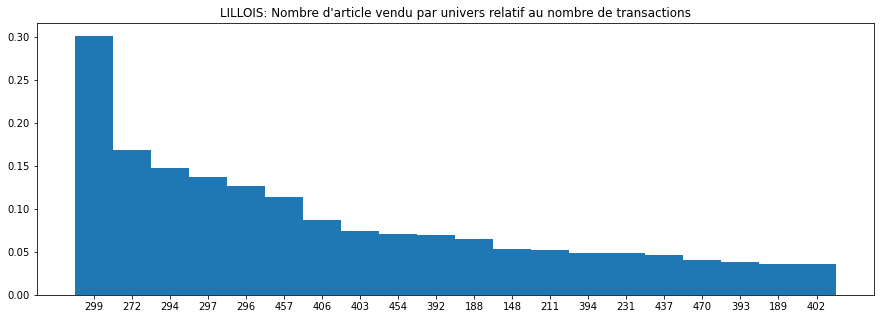

0.0024875621890547263
Running Apriori
45
{250} -> {272} (conf: 0.203, supp: 0.004, lift: 1.419, conv: 1.075)
{188} -> {272} (conf: 0.206, supp: 0.010, lift: 1.440, conv: 1.079)
{296} -> {299} (conf: 0.212, supp: 0.014, lift: 1.647, conv: 1.106)
{231} -> {272} (conf: 0.238, supp: 0.009, lift: 1.665, conv: 1.125)
{452} -> {297} (conf: 0.201, supp: 0.006, lift: 1.766, conv: 1.109)
{294, 299} -> {297} (conf: 0.201, supp: 0.003, lift: 1.769, conv: 1.110)
{183} -> {297} (conf: 0.203, supp: 0.005, lift: 1.784, conv: 1.112)
{303} -> {297} (conf: 0.212, supp: 0.003, lift: 1.865, conv: 1.125)
{225} -> {299} (conf: 0.246, supp: 0.004, lift: 1.910, conv: 1.155)
{296} -> {297} (conf: 0.219, supp: 0.014, lift: 1.927, conv: 1.135)
{296, 297} -> {299} (conf: 0.253, supp: 0.004, lift: 1.964, conv: 1.166)
{83} -> {297} (conf: 0.242, supp: 0.004, lift: 2.126, conv: 1.169)
{74} -> {297} (conf: 0.251, supp: 0.004, lift: 2.205, conv: 1.183)
{296, 299} -> {297} (conf: 0.262, supp: 0.004, lift: 2.298, conv: 1

 Univ_KEY                     Univ_1                    Univ_2 Univ_3   Univ_4
      454 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS  CHIPS > 1 PERS


Rule :  {298} -> {296} (conf: 0.254, supp: 0.003, lift: 3.971, conv: 1.254)
 Univ_KEY         Univ_1                       Univ_2            Univ_3            Univ_4
      298 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS PETITES BAGUETTES PETITES BAGUETTES
->
 Univ_KEY         Univ_1                       Univ_2     Univ_3     Univ_4
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS MINI PAINS MINI PAINS


Rule :  {406} -> {403} (conf: 0.209, supp: 0.013, lift: 3.973, conv: 1.198)
 Univ_KEY        Univ_1         Univ_2       Univ_3         Univ_4
      406 PRET A MANGER PLATS PREPARES ITALIAN FOOD PLATS ITALIENS
->
 Univ_KEY        Univ_1         Univ_2         Univ_3          Univ_4
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD PLATS TRADITION


Rule :  {403} -> {406} (conf: 0.248, supp: 0.013, lift: 3.973, conv: 1.2

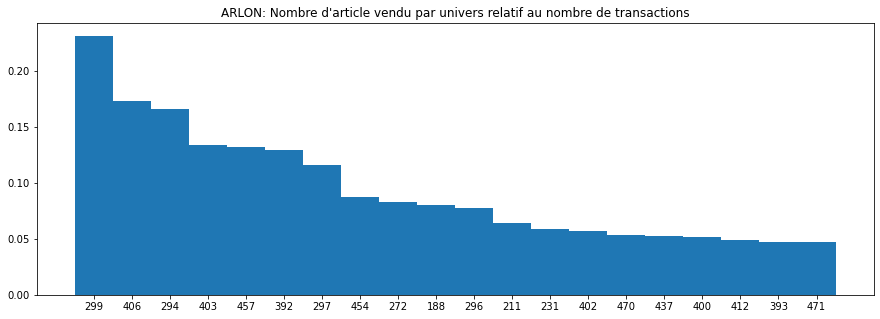

0.0024813895781637717
Running Apriori
77
{83} -> {294} (conf: 0.205, supp: 0.004, lift: 1.550, conv: 1.092)
{461} -> {294} (conf: 0.207, supp: 0.004, lift: 1.567, conv: 1.095)
{183} -> {294} (conf: 0.211, supp: 0.005, lift: 1.593, conv: 1.099)
{225} -> {299} (conf: 0.200, supp: 0.004, lift: 1.687, conv: 1.102)
{296} -> {299} (conf: 0.201, supp: 0.009, lift: 1.691, conv: 1.103)
{297, 299} -> {294} (conf: 0.228, supp: 0.003, lift: 1.723, conv: 1.124)
{328} -> {294} (conf: 0.234, supp: 0.003, lift: 1.765, conv: 1.132)
{452} -> {406} (conf: 0.209, supp: 0.007, lift: 1.766, conv: 1.115)
{57} -> {406} (conf: 0.209, supp: 0.004, lift: 1.767, conv: 1.115)
{13} -> {294} (conf: 0.238, supp: 0.005, lift: 1.801, conv: 1.139)
{18} -> {294} (conf: 0.240, supp: 0.003, lift: 1.815, conv: 1.142)
{142} -> {406} (conf: 0.216, supp: 0.003, lift: 1.825, conv: 1.125)
{296} -> {294} (conf: 0.242, supp: 0.011, lift: 1.829, conv: 1.145)
{144} -> {406} (conf: 0.226, supp: 0.004, lift: 1.905, conv: 1.138)
{394} 

 Univ_KEY          Univ_1  Univ_2    Univ_3   Univ_4
      475 PRET A CUISINER FROMAGE PATE DURE TRANCHES
->
 Univ_KEY         Univ_1                       Univ_2    Univ_3    Univ_4
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES BAGUETTES


Rule :  {407} -> {403} (conf: 0.215, supp: 0.003, lift: 2.458, conv: 1.162)
 Univ_KEY        Univ_1         Univ_2      Univ_3      Univ_4
      407 PRET A MANGER PLATS PREPARES INDIAN FOOD INDIAN FOOD
->
 Univ_KEY        Univ_1         Univ_2         Univ_3          Univ_4
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD PLATS TRADITION


Rule :  {52} -> {297} (conf: 0.244, supp: 0.004, lift: 2.470, conv: 1.192)
 Univ_KEY          Univ_1  Univ_2     Univ_3     Univ_4
       52 PRET A CUISINER FROMAGE PATE MOLLE PATE MOLLE
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {406} -> {403} (conf: 0.218, supp: 0.026, lift: 2.501, con

 Univ_KEY                     Univ_1                    Univ_2         Univ_3         Univ_4
      319 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS BISCUITS SALES BISCUITS SALES
->
 Univ_KEY                     Univ_1                    Univ_2 Univ_3   Univ_4
      454 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS  CHIPS > 1 PERS


Rule :  {418} -> {403} (conf: 0.431, supp: 0.003, lift: 4.939, conv: 1.605)
 Univ_KEY        Univ_1         Univ_2              Univ_3  Univ_4
      418 PRET A MANGER PLATS PREPARES COMPOSANTS DE REPAS LEGUMES
->
 Univ_KEY        Univ_1         Univ_2         Univ_3          Univ_4
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD PLATS TRADITION


Rule :  {407} -> {402} (conf: 0.223, supp: 0.003, lift: 5.093, conv: 1.231)
 Univ_KEY        Univ_1         Univ_2      Univ_3      Univ_4
      407 PRET A MANGER PLATS PREPARES INDIAN FOOD INDIAN FOOD
->
 Univ_KEY        Univ_1         Univ_2       Univ_3       Univ_4
      402 PRET A MANGER PL

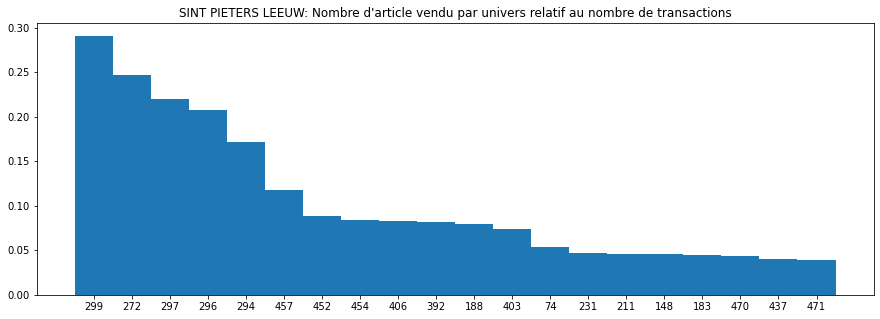

0.0024330900243309003
Running Apriori
146
{299, 452} -> {272} (conf: 0.200, supp: 0.003, lift: 1.020, conv: 1.005)
{457} -> {272} (conf: 0.200, supp: 0.019, lift: 1.021, conv: 1.005)
{472} -> {272} (conf: 0.205, supp: 0.003, lift: 1.045, conv: 1.011)
{250} -> {272} (conf: 0.211, supp: 0.004, lift: 1.073, conv: 1.018)
{297, 457} -> {272} (conf: 0.211, supp: 0.003, lift: 1.074, conv: 1.019)
{299, 457} -> {272} (conf: 0.214, supp: 0.003, lift: 1.091, conv: 1.023)
{300} -> {297} (conf: 0.201, supp: 0.003, lift: 1.169, conv: 1.036)
{452, 457} -> {297} (conf: 0.205, supp: 0.003, lift: 1.195, conv: 1.042)
{439} -> {297} (conf: 0.208, supp: 0.005, lift: 1.213, conv: 1.046)
{452, 454} -> {297} (conf: 0.209, supp: 0.003, lift: 1.218, conv: 1.047)
{147} -> {297} (conf: 0.209, supp: 0.004, lift: 1.219, conv: 1.047)
{452, 457} -> {272} (conf: 0.245, supp: 0.004, lift: 1.249, conv: 1.065)
{114} -> {297} (conf: 0.216, supp: 0.002, lift: 1.258, conv: 1.056)
{181} -> {297} (conf: 0.217, supp: 0.003, li

 Univ_KEY           Univ_1  Univ_2         Univ_3 Univ_4
      183 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES FRUITS
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {121} -> {297} (conf: 0.243, supp: 0.003, lift: 1.415, conv: 1.094)
 Univ_KEY  Univ_1   Univ_2    Univ_3    Univ_4
      121 DESSERT CHOCOLAT TABLETTES TABLETTES
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {176} -> {297} (conf: 0.244, supp: 0.004, lift: 1.423, conv: 1.096)
 Univ_KEY           Univ_1 Univ_2 Univ_3 Univ_4
      176 FRUITS   LEGUMES FRUITS VERGER VERGER
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {438} -> {297} (conf: 0.270, supp: 0.002, lift: 1.575, conv: 1.135)
 Univ_KEY   Univ_1    Univ_2        Univ_3   

 Univ_KEY          Univ_1  Univ_2    Univ_3   Univ_4
      475 PRET A CUISINER FROMAGE PATE DURE TRANCHES
->
 Univ_KEY         Univ_1                       Univ_2    Univ_3    Univ_4
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES BAGUETTES


Rule :  {462} -> {297} (conf: 0.338, supp: 0.003, lift: 1.967, conv: 1.250)
 Univ_KEY          Univ_1  Univ_2    Univ_3 Univ_4
      462 PRET A CUISINER FROMAGE PATE DURE   BLOC
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {296, 297} -> {299} (conf: 0.253, supp: 0.007, lift: 1.981, conv: 1.168)
 Univ_KEY         Univ_1                       Univ_2     Univ_3     Univ_4
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS MINI PAINS MINI PAINS
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS      PAINS      PAINS
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNO

 Univ_KEY          Univ_1                       Univ_2    Univ_3    Univ_4
       74 PRET A CUISINER                       SPREAD    SPREAD    SPREAD
      294  PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES BAGUETTES
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {475} -> {452} (conf: 0.209, supp: 0.005, lift: 2.513, conv: 1.159)
 Univ_KEY          Univ_1  Univ_2    Univ_3   Univ_4
      475 PRET A CUISINER FROMAGE PATE DURE TRANCHES
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {176} -> {452} (conf: 0.210, supp: 0.003, lift: 2.524, conv: 1.160)
 Univ_KEY           Univ_1 Univ_2 Univ_3 Univ_4
      176 FRUITS   LEGUMES FRUITS V

 Univ_KEY         Univ_1       Univ_2       Univ_3       Univ_4
      437 PETIT DEJEUNER CAFE SERVICE CAFE SERVICE CAFE SERVICE
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {297, 457} -> {452} (conf: 0.266, supp: 0.003, lift: 3.198, conv: 1.249)
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS
      457       BOISSONS                  SOFT DRINKS   SODA  COLAS
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {74, 452} -> {294} (conf: 0.398, supp: 0.003, lift: 3.260, conv: 1.459)
 Univ_KEY          Univ_1                       Univ_2                       Univ_3                       Univ_4
       74 PRET A CUISINER               

 Univ_KEY          Univ_1  Univ_2                   Univ_3                   Univ_4
       57 PRET A CUISINER FROMAGE FROMAGES RAPES   COPEAUX FROMAGES RAPES   COPEAUX


Rule :  {328} -> {461} (conf: 0.364, supp: 0.003, lift: 18.339, conv: 1.541)
 Univ_KEY                     Univ_1 Univ_2   Univ_3   Univ_4
      328 APERITIF   ENTREES   TAPAS  TAPAS FROMAGES FROMAGES
->
 Univ_KEY                     Univ_1 Univ_2                  Univ_3                         Univ_4
      461 APERITIF   ENTREES   TAPAS  TAPAS CHARCUTERIE  SAUCISSONS PETITS SAUCISSONS (MINI/TRANC)
44285
To less data ...
306966


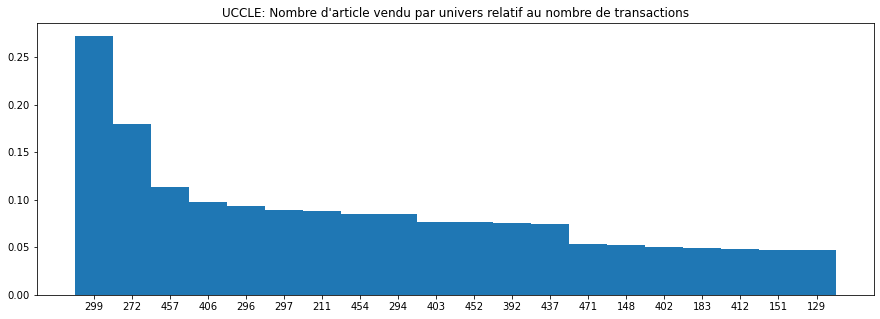

0.0024509803921568627
Running Apriori
67
{188} -> {272} (conf: 0.211, supp: 0.006, lift: 1.389, conv: 1.075)
{299, 457} -> {272} (conf: 0.213, supp: 0.003, lift: 1.402, conv: 1.078)
{231} -> {272} (conf: 0.220, supp: 0.006, lift: 1.448, conv: 1.087)
{231} -> {299} (conf: 0.205, supp: 0.006, lift: 1.537, conv: 1.090)
{392, 457} -> {299} (conf: 0.215, supp: 0.003, lift: 1.609, conv: 1.104)
{225} -> {299} (conf: 0.221, supp: 0.006, lift: 1.659, conv: 1.113)
{296} -> {299} (conf: 0.222, supp: 0.011, lift: 1.665, conv: 1.114)
{437} -> {299} (conf: 0.335, supp: 0.020, lift: 2.510, conv: 1.303)
{438} -> {299} (conf: 0.346, supp: 0.003, lift: 2.589, conv: 1.324)
{74} -> {297} (conf: 0.208, supp: 0.004, lift: 2.682, conv: 1.165)
{83} -> {297} (conf: 0.209, supp: 0.004, lift: 2.690, conv: 1.166)
{176} -> {297} (conf: 0.209, supp: 0.003, lift: 2.700, conv: 1.167)
{176} -> {452} (conf: 0.201, supp: 0.003, lift: 2.810, conv: 1.162)
{52} -> {297} (conf: 0.218, supp: 0.003, lift: 2.816, conv: 1.180)


 Univ_KEY          Univ_1      Univ_2  Univ_3        Univ_4
       62 PRET A CUISINER CHARCUTERIE JAMBONS JAMBONS CUITS
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {183} -> {452} (conf: 0.222, supp: 0.008, lift: 3.114, conv: 1.194)
 Univ_KEY           Univ_1  Univ_2         Univ_3 Univ_4
      183 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES FRUITS
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {300} -> {452} (conf: 0.223, supp: 0.004, lift: 3.118, conv: 1.195)
 Univ_KEY         Univ_1                   Univ_2                   Univ_3                   Univ_4
      300 PETIT DEJEUNER BOULANGERIE PRE EMBALLEE BOULANGERIE PRE EMBALLEE BOULA

 Univ_KEY           Univ_1 Univ_2   Univ_3   Univ_4
      171 FRUITS   LEGUMES FRUITS EXOTIQUE EXOTIQUE


Rule :  {408} -> {412} (conf: 0.286, supp: 0.004, lift: 8.151, conv: 1.352)
 Univ_KEY        Univ_1         Univ_2        Univ_3          Univ_4
      408 PRET A MANGER PLATS PREPARES JAPANESE FOOD PLATS JAPONNAIS
->
 Univ_KEY        Univ_1         Univ_2    Univ_3    Univ_4
      412 PRET A MANGER PLATS PREPARES THAI FOOD THAI FOOD


Rule :  {183} -> {13} (conf: 0.225, supp: 0.008, lift: 8.342, conv: 1.256)
 Univ_KEY           Univ_1  Univ_2         Univ_3 Univ_4
      183 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES FRUITS
->
 Univ_KEY          Univ_1        Univ_2  Univ_3  Univ_4
       13 PRET A CUISINER 4 ET 5  GAMME SALADES SALADES


Rule :  {13} -> {183} (conf: 0.281, supp: 0.008, lift: 8.342, conv: 1.345)
 Univ_KEY          Univ_1        Univ_2  Univ_3  Univ_4
       13 PRET A CUISINER 4 ET 5  GAMME SALADES SALADES
->
 Univ_KEY           Univ_1  Univ_2         Univ_3 Univ_4
    

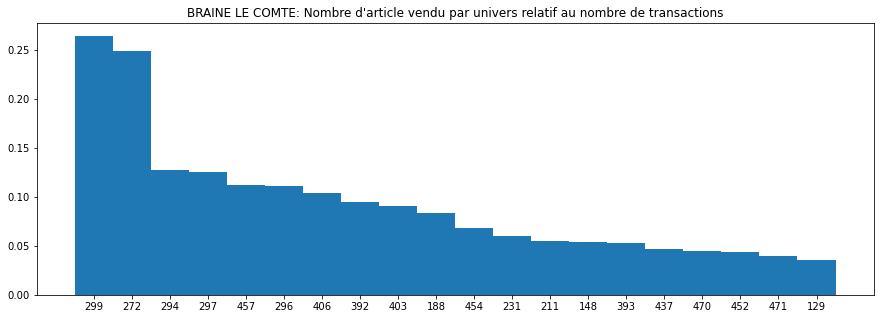

0.0024509803921568627
Running Apriori
67
{198} -> {272} (conf: 0.215, supp: 0.002, lift: 1.014, conv: 1.004)
{188} -> {272} (conf: 0.224, supp: 0.014, lift: 1.057, conv: 1.016)
{250} -> {272} (conf: 0.249, supp: 0.005, lift: 1.177, conv: 1.050)
{311} -> {272} (conf: 0.278, supp: 0.006, lift: 1.314, conv: 1.092)
{126} -> {272} (conf: 0.279, supp: 0.003, lift: 1.316, conv: 1.093)
{231} -> {272} (conf: 0.286, supp: 0.014, lift: 1.352, conv: 1.104)
{294, 296} -> {299} (conf: 0.222, supp: 0.003, lift: 1.792, conv: 1.126)
{296} -> {299} (conf: 0.224, supp: 0.015, lift: 1.814, conv: 1.130)
{183} -> {297} (conf: 0.201, supp: 0.003, lift: 1.869, conv: 1.117)
{294, 299} -> {297} (conf: 0.204, supp: 0.002, lift: 1.896, conv: 1.121)
{303} -> {297} (conf: 0.206, supp: 0.003, lift: 1.911, conv: 1.124)
{296, 297} -> {299} (conf: 0.240, supp: 0.003, lift: 1.943, conv: 1.154)
{296} -> {297} (conf: 0.210, supp: 0.014, lift: 1.950, conv: 1.130)
{294, 296} -> {297} (conf: 0.217, supp: 0.003, lift: 2.017, 

 Univ_KEY         Univ_1                       Univ_2    Univ_3    Univ_4
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES BAGUETTES


Rule :  {74} -> {297} (conf: 0.275, supp: 0.004, lift: 2.555, conv: 1.231)
 Univ_KEY          Univ_1 Univ_2 Univ_3 Univ_4
       74 PRET A CUISINER SPREAD SPREAD SPREAD
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {271} -> {272} (conf: 0.543, supp: 0.009, lift: 2.563, conv: 1.724)
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      271 TABACS   PRESSE TABAC   ACCESSOIRE TABAC   ACCESSOIRE TABAC   ACCESSOIRE
->
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      272 TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES TABAC   CIGARETTES


Rule :  {393} -> {392} (conf: 0.206, supp: 0.009, lift: 2.707, conv: 1.164)
 Univ_KEY        Univ_1     Univ_2            Univ_

 Univ_KEY   Univ_1         Univ_2                 Univ_3                 Univ_4
      448 ECONOMAT ECONOMAT AUTRE FOURNITURE ET MATERIEL FOURNITURE ET MATERIEL


Rule :  {296, 448} -> {297} (conf: 0.885, supp: 0.003, lift: 8.220, conv: 7.771)
 Univ_KEY         Univ_1                       Univ_2                 Univ_3                 Univ_4
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS             MINI PAINS             MINI PAINS
      448       ECONOMAT               ECONOMAT AUTRE FOURNITURE ET MATERIEL FOURNITURE ET MATERIEL
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {294, 297} -> {448} (conf: 0.254, supp: 0.004, lift: 8.277, conv: 1.299)
 Univ_KEY         Univ_1                       Univ_2    Univ_3    Univ_4
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES BAGUETTES
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS     PAINS     PAINS
->
 Univ_KEY 

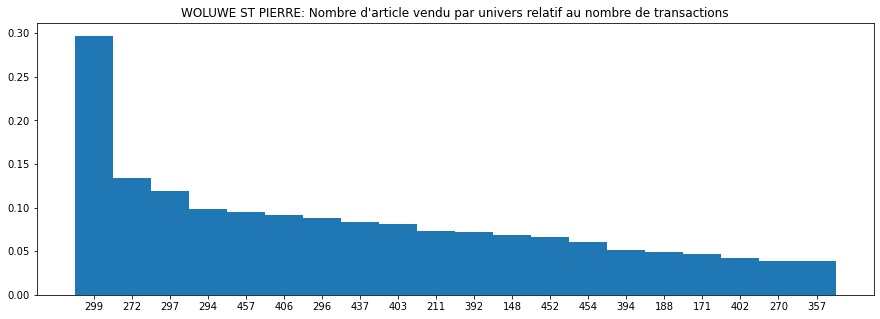

0.0024390243902439024
Running Apriori
33
{296} -> {299} (conf: 0.238, supp: 0.012, lift: 1.583, conv: 1.115)
{225} -> {299} (conf: 0.240, supp: 0.006, lift: 1.596, conv: 1.118)
{220} -> {299} (conf: 0.273, supp: 0.003, lift: 1.816, conv: 1.169)
{198} -> {299} (conf: 0.290, supp: 0.004, lift: 1.926, conv: 1.196)
{231} -> {272} (conf: 0.229, supp: 0.005, lift: 2.003, conv: 1.149)
{83} -> {297} (conf: 0.235, supp: 0.004, lift: 2.282, conv: 1.172)
{18} -> {297} (conf: 0.251, supp: 0.003, lift: 2.437, conv: 1.197)
{74} -> {297} (conf: 0.254, supp: 0.002, lift: 2.468, conv: 1.202)
{437} -> {299} (conf: 0.372, supp: 0.025, lift: 2.471, conv: 1.352)
{52} -> {297} (conf: 0.263, supp: 0.003, lift: 2.558, conv: 1.217)
{62} -> {297} (conf: 0.275, supp: 0.004, lift: 2.677, conv: 1.238)
{62} -> {294} (conf: 0.206, supp: 0.003, lift: 2.701, conv: 1.164)
{475} -> {297} (conf: 0.323, supp: 0.005, lift: 3.143, conv: 1.326)
{406} -> {403} (conf: 0.200, supp: 0.014, lift: 3.329, conv: 1.175)
{403} -> {406

 Univ_KEY        Univ_1         Univ_2        Univ_3          Univ_4
      408 PRET A MANGER PLATS PREPARES JAPANESE FOOD PLATS JAPONNAIS
->
 Univ_KEY        Univ_1         Univ_2       Univ_3       Univ_4
      402 PRET A MANGER PLATS PREPARES CHINESE FOOD CHINESE FOOD


Rule :  {448} -> {297} (conf: 0.966, supp: 0.004, lift: 9.393, conv: 26.326)
 Univ_KEY   Univ_1         Univ_2                 Univ_3                 Univ_4
      448 ECONOMAT ECONOMAT AUTRE FOURNITURE ET MATERIEL FOURNITURE ET MATERIEL
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {475} -> {62} (conf: 0.201, supp: 0.003, lift: 14.623, conv: 1.234)
 Univ_KEY          Univ_1  Univ_2    Univ_3   Univ_4
      475 PRET A CUISINER FROMAGE PATE DURE TRANCHES
->
 Univ_KEY          Univ_1      Univ_2  Univ_3        Univ_4
       62 PRET A CUISINER CHARCUTERIE JAMBONS JAMBONS CUITS


Rule :  {62} -> {475} (conf: 0.220, supp: 

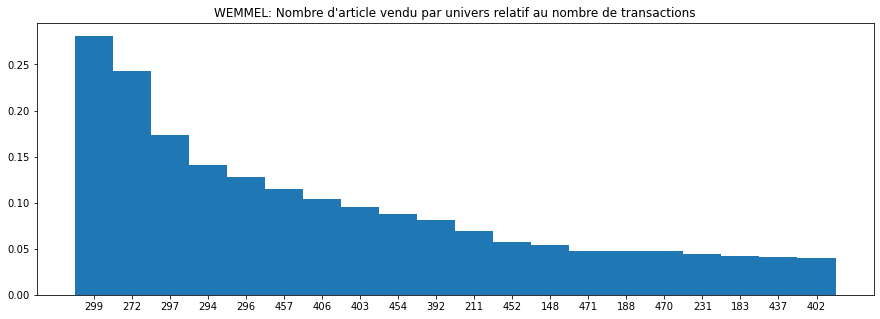

0.0024390243902439024
Running Apriori
87
{452} -> {272} (conf: 0.204, supp: 0.011, lift: 1.000, conv: 1.000)
{211} -> {272} (conf: 0.205, supp: 0.012, lift: 1.004, conv: 1.001)
{129} -> {272} (conf: 0.206, supp: 0.004, lift: 1.009, conv: 1.002)
{471} -> {272} (conf: 0.209, supp: 0.008, lift: 1.026, conv: 1.007)
{472} -> {272} (conf: 0.226, supp: 0.003, lift: 1.107, conv: 1.028)
{457} -> {272} (conf: 0.240, supp: 0.022, lift: 1.176, conv: 1.047)
{297, 457} -> {272} (conf: 0.251, supp: 0.003, lift: 1.229, conv: 1.063)
{299, 457} -> {272} (conf: 0.264, supp: 0.003, lift: 1.294, conv: 1.081)
{126} -> {272} (conf: 0.266, supp: 0.003, lift: 1.301, conv: 1.084)
{198} -> {272} (conf: 0.269, supp: 0.005, lift: 1.317, conv: 1.089)
{452, 457} -> {272} (conf: 0.269, supp: 0.003, lift: 1.317, conv: 1.089)
{250} -> {272} (conf: 0.270, supp: 0.008, lift: 1.325, conv: 1.091)
{188} -> {272} (conf: 0.272, supp: 0.009, lift: 1.334, conv: 1.094)
{211, 457} -> {272} (conf: 0.291, supp: 0.003, lift: 1.427, 

 Univ_KEY          Univ_1 Univ_2 Univ_3 Univ_4
       83 PRET A CUISINER  OEUFS  OEUFS  OEUFS
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {443} -> {299} (conf: 0.241, supp: 0.005, lift: 1.834, conv: 1.144)
 Univ_KEY        Univ_1       Univ_2 Univ_3 Univ_4
      443 PRET A MANGER MEUBLE CHAUD AUTRES AUTRES
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {296, 299} -> {297} (conf: 0.273, supp: 0.004, lift: 1.871, conv: 1.175)
 Univ_KEY         Univ_1                       Univ_2        Univ_3        Univ_4
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS    MINI PAINS    MINI PAINS
      299 PETIT DEJEUNER                 VIENNOISERIE VIENNOISERIES VIENNOISERIES
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANT

 Univ_KEY   Univ_1    Univ_2        Univ_3        Univ_4
      438 BOISSONS JUS ZUMEX JUS ZUMEX >1P JUS ZUMEX >1P
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {408} -> {406} (conf: 0.218, supp: 0.003, lift: 3.006, conv: 1.186)
 Univ_KEY        Univ_1         Univ_2        Univ_3          Univ_4
      408 PRET A MANGER PLATS PREPARES JAPANESE FOOD PLATS JAPONNAIS
->
 Univ_KEY        Univ_1         Univ_2       Univ_3         Univ_4
      406 PRET A MANGER PLATS PREPARES ITALIAN FOOD PLATS ITALIENS


Rule :  {437} -> {299} (conf: 0.395, supp: 0.013, lift: 3.014, conv: 1.436)
 Univ_KEY         Univ_1       Univ_2       Univ_3       Univ_4
      437 PETIT DEJEUNER CAFE SERVICE CAFE SERVICE CAFE SERVICE
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {52} -> {294} (conf: 0.319, supp: 0.004, lift: 

42856
To less data ...


In [16]:
conn = engine.connect()
for mag_key in all_mag_key:
    start    = time()
    mag_lib  = all_mag_lib[mag_key]
    mag_tran = all_mag_tra[mag_key]
    

    mag_rec_article = {}

    for t in mag_tran:
        for art in t:
            if not str(art) in mag_rec_article.keys():
                mag_rec_article[str(art)] = 0
            mag_rec_article[str(art)]+=1

    for k in mag_rec_article.keys():
        mag_rec_article[k]/= len(mag_tran)
    print(len(mag_tran))
    
    
    mag_rec_article = {k: v for k, v in sorted(mag_rec_article.items(), key=lambda item: item[1], reverse = True)}
    mag_nbr_univ = len(mag_rec_article.keys())
    
    if len(mag_tran) < mag_nbr_univ**2:
        print("To less data ...")
        continue
    
    fig = plt.figure(figsize=(15, 5))
    plt.bar(list(mag_rec_article.keys())[:min(20, mag_nbr_univ)]
                ,list(mag_rec_article.values())[:min(20, mag_nbr_univ)],1)

    plt.title(mag_lib + ": Nombre d'article vendu par univers relatif au nombre de transactions")

    if save_fig:
        plt.savefig(save_folder+"/MAG-"+str(mag_key)+"-"+mag_lib+"-Proportion-Article.jpg")
    plt.show()
    
    min_supp = 1/mag_nbr_univ if min_support == 0 else min_support
    print(min_supp)
 
    print("Running Apriori")
    _, mag_rules = apriori(mag_tran, min_support=min_supp, min_confidence=min_confidence)
    
    print(len(mag_rules))
    for rule in sorted(mag_rules, key=lambda rule: rule.lift):
        print(rule)

    # environ 5s   
    print("Time Taken to run Apriori Algorithm : ~" + str(int(time() - start)) + "secondes") 
    

    for rule in sorted(mag_rules, key=lambda rule: rule.lift):
        print("\n\nRule : ", rule)

        sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY] AS Univ_KEY, 
        ['''  + TABLE_UNIVERS  + '''.Libelle_univers1_FR] AS Univ_1 ''' + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR] AS Univ_2 ''')*int(Univers_Depth >= 2) + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR] AS Univ_3 ''')*int(Univers_Depth >= 3) + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR] AS Univ_4 ''')*int(Univers_Depth >= 4) + '''
        FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']
        WHERE '''
        for v in rule.lhs:
            sql_command += "[" + TABLE_UNIVERS  + ".KEY] = " + str(v) + "\nOR "
        sql_command = sql_command[:-3]

        df_libele = pd.read_sql(sql_command, conn)

        print(df_libele.to_string(index=False))
        print('->')

        sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY] AS Univ_KEY, 
        ['''  + TABLE_UNIVERS  + '''.Libelle_univers1_FR] AS Univ_1 ''' + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR] AS Univ_2 ''')*int(Univers_Depth >= 2) + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR] AS Univ_3 ''')*int(Univers_Depth >= 3) + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR] AS Univ_4 ''')*int(Univers_Depth >= 4) + '''
        FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']
        WHERE '''
        for v in rule.rhs:
            sql_command += "[" + TABLE_UNIVERS  + ".KEY] = " + str(v) + "\nOR "
        sql_command = sql_command[:-3]

        df_libele = pd.read_sql(sql_command, conn)

        print(df_libele.to_string(index=False))

conn.close()    


In [17]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~1166secondes
